In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import torch
import math
import pickle

In [3]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Concatenate
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import MinMaxScaler

In [4]:
ROA = '/content/drive/MyDrive/df_ROA.pkl'
ROC = '/content/drive/MyDrive/df_ROC.pkl'
RGA = '/content/drive/MyDrive/df_RGA.pkl'
RGC = '/content/drive/MyDrive/df_RGC.pkl'
with open(ROA, 'rb') as file:
    dataROA = pickle.load(file)
with open(ROC, 'rb') as file:
    dataROC = pickle.load(file)
with open(RGA, 'rb') as file:
    dataRGA = pickle.load(file)
with open(RGC, 'rb') as file:
    dataRGC = pickle.load(file)

In [5]:
dataROA.shape

(103, 19)

In [6]:
# Contar valores nulos en el índice 'Indice_VIS' en cada dataset
nulos_ROA_VIS = dataROA['Indice_VIS'].value_counts().get('-', 0)
nulos_ROC_VIS = dataROC['Indice_VIS'].value_counts().get('-', 0)
nulos_RGA_VIS = dataRGA['Indice_VIS'].value_counts().get('-', 0)
nulos_RGC_VIS = dataRGC['Indice_VIS'].value_counts().get('-', 0)

# Contar valores nulos en el índice 'Indice_VEST' en cada dataset
nulos_ROA_VEST = dataROA['Indice_VEST'].value_counts().get('-', 0)
nulos_ROC_VEST = dataROC['Indice_VEST'].value_counts().get('-', 0)
nulos_RGA_VEST = dataRGA['Indice_VEST'].value_counts().get('-', 0)
nulos_RGC_VEST = dataRGC['Indice_VEST'].value_counts().get('-', 0)

# Contar valores nulos en el índice 'Indice_VEST' en cada dataset
nulos_ROA_SOM = dataROA['Indice_SOM'].value_counts().get('-', 0)
nulos_ROC_SOM = dataROC['Indice_SOM'].value_counts().get('-', 0)
nulos_RGA_SOM = dataRGA['Indice_SOM'].value_counts().get('-', 0)
nulos_RGC_SOM = dataRGC['Indice_SOM'].value_counts().get('-', 0)

# Imprimir la cantidad de valores nulos en cada índice en cada dataset
print("Valores nulos en el índice 'Indice_SOM':")
print("ROA:", nulos_ROA_SOM)
print("ROC:", nulos_ROC_SOM)
print("RGA:", nulos_RGA_SOM)
print("RGC:", nulos_RGC_SOM)

# Imprimir la cantidad de valores nulos en cada índice en cada dataset
print("Valores nulos en el índice 'Indice_VIS':")
print("ROA:", nulos_ROA_VIS)
print("ROC:", nulos_ROC_VIS)
print("RGA:", nulos_RGA_VIS)
print("RGC:", nulos_RGC_VIS)

print("\nValores nulos en el índice 'Indice_VEST':")
print("ROA:", nulos_ROA_VEST)
print("ROC:", nulos_ROC_VEST)
print("RGA:", nulos_RGA_VEST)
print("RGC:", nulos_RGC_VEST)

Valores nulos en el índice 'Indice_SOM':
ROA: 0
ROC: 0
RGA: 0
RGC: 0
Valores nulos en el índice 'Indice_VIS':
ROA: 0
ROC: 0
RGA: 0
RGC: 0

Valores nulos en el índice 'Indice_VEST':
ROA: 4
ROC: 4
RGA: 4
RGC: 0


In [7]:
dataROA = dataROA.drop(dataROA[dataROA['Indice_VIS'] == '-'].index)
dataROC = dataROC.drop(dataROC[dataROC['Indice_VIS'] == '-'].index)
dataRGA = dataRGA.drop(dataRGA[dataRGA['Indice_VIS'] == '-'].index)
dataRGC = dataRGC.drop(dataRGC[dataRGC['Indice_VIS'] == '-'].index)

dataROA = dataROA.drop(dataROA[dataROA['Indice_VEST'] == '-'].index)
dataROC = dataROC.drop(dataROC[dataROC['Indice_VEST'] == '-'].index)
dataRGA = dataRGA.drop(dataRGA[dataRGA['Indice_VEST'] == '-'].index)
dataRGC = dataRGC.drop(dataRGC[dataRGC['Indice_VEST'] == '-'].index)

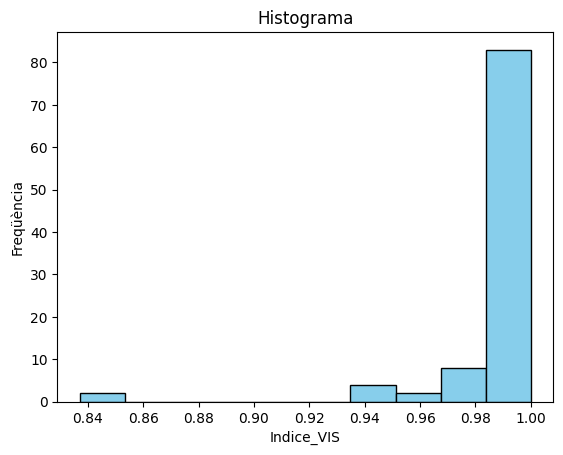

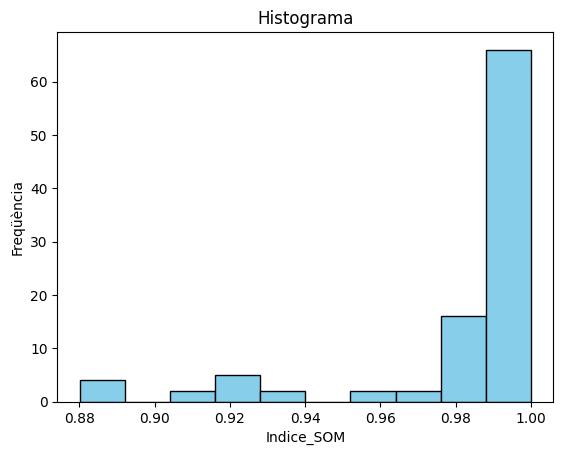

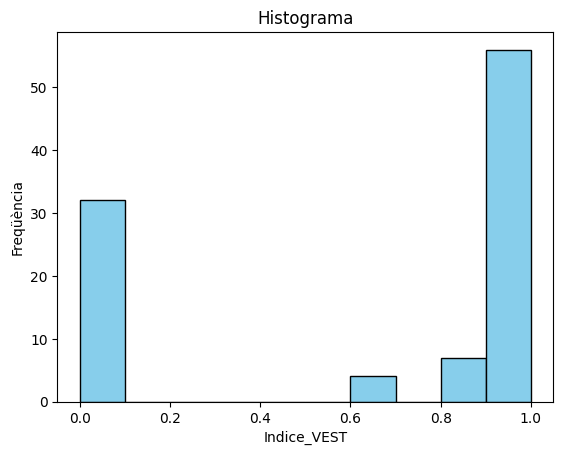

In [8]:
Índex_VIS = dataROA['Indice_VIS'].astype(float)/100
Índex_SOM = dataROA['Indice_SOM'].astype(float)/100
Índex_VEST = dataROA['Indice_VEST'].astype(float)/100

pyplot.hist(Índex_VIS, color='skyblue', edgecolor='black')
pyplot.title('Histograma')
pyplot.xlabel('Indice_VIS')
pyplot.ylabel('Freqüència')
pyplot.show()

pyplot.hist(Índex_SOM, color='skyblue', edgecolor='black')
pyplot.title('Histograma')
pyplot.xlabel('Indice_SOM')
pyplot.ylabel('Freqüència')
pyplot.show()

pyplot.hist(Índex_VEST, color='skyblue', edgecolor='black')
pyplot.title('Histograma')
pyplot.xlabel('Indice_VEST')
pyplot.ylabel('Freqüència')
pyplot.show()

In [31]:
ids = dataRGC['id']
ids = ids.reset_index(drop=True)

In [32]:
X = dataRGC.drop(columns = ['id','action','rep','time','Indice_VIS','Indice_VEST','Indice_SOM'])
X = X.reset_index(drop=True)
X.shape

(102, 12)

In [33]:
len(X['acelerometro_x'][0])

1127

In [25]:
X.columns

Index(['acelerometro_x', 'acelerometro_y', 'acelerometro_z', 'giroscopo_x',
       'giroscopo_y', 'giroscopo_z', 'compass_x', 'compass_y', 'compass_z',
       'gravity_vector_x', 'gravity_vector_y', 'gravity_vector_z'],
      dtype='object')

In [34]:
import matplotlib.pyplot as plt

Índex_VEST = dataRGC['Indice_VEST'].astype(float)/100
label = Índex_VEST.astype(np.float32)
label = label.reset_index(drop=True)
label = label*100

for i in range(X.shape[0]):
  tiempo = np.arange(0, 1150) * 0.025
  aceleracion_x = [int(elemento) for elemento in X.loc[i, 'compass_x']]  # Valores de aceleración en el eje x
  aceleracion_y = [int(elemento) for elemento in X.loc[i, 'compass_y']]  # Valores de aceleración en el eje y
  aceleracion_z =  [int(elemento) for elemento in X.loc[i, 'compass_z']]  # Valores de aceleración en el eje z

  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

  ax1.plot(tiempo, aceleracion_x, color = 'blue')
  ax1.set_ylabel('Magnetòmetre X')

  ax2.plot(tiempo, aceleracion_y,color='red')
  ax2.set_ylabel('Magnetòmetre Y')

  ax3.plot(tiempo, aceleracion_z,color='green')
  ax3.set_xlabel('Temps (s)')
  ax3.set_ylabel('Magnetòmetre Z')

  titol = 'Magnetòmetre - Índex VEST: {}'.format(label[i])
  fig.suptitle(titol)

  id = ids[i]
  ax1.legend([id], loc='upper right')
  ax2.legend([id], loc='upper right')
  ax3.legend([id], loc='upper right')

  plt.tight_layout()
  nombre_archivo = "gir_{}.png".format(i)
  if label[i]<0.5:
    ruta_archivo = '/content/drive/My Drive/graf_mag/rgc_pos/' + nombre_archivo
  else:
    ruta_archivo = '/content/drive/My Drive/graf_mag/rgc_neg/' + nombre_archivo

  plt.savefig(ruta_archivo)

# Orientació amb filtre complementari

<ipython-input-37-36cfb369252e>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


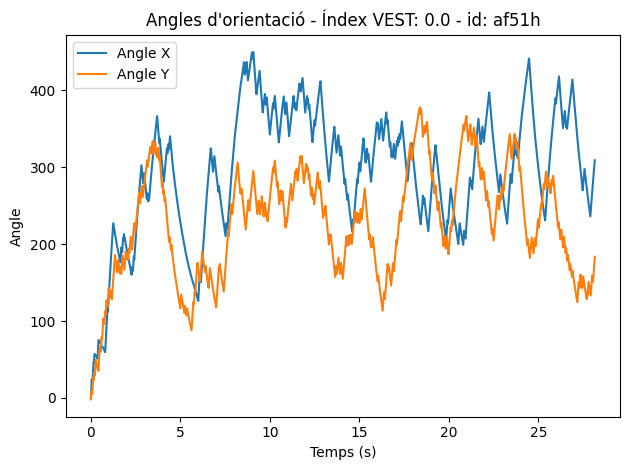

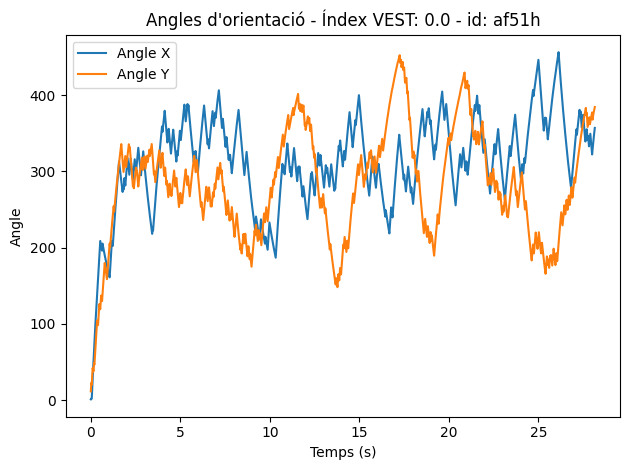

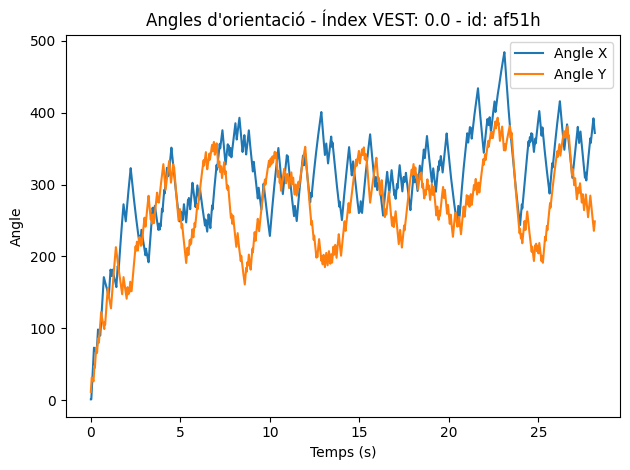

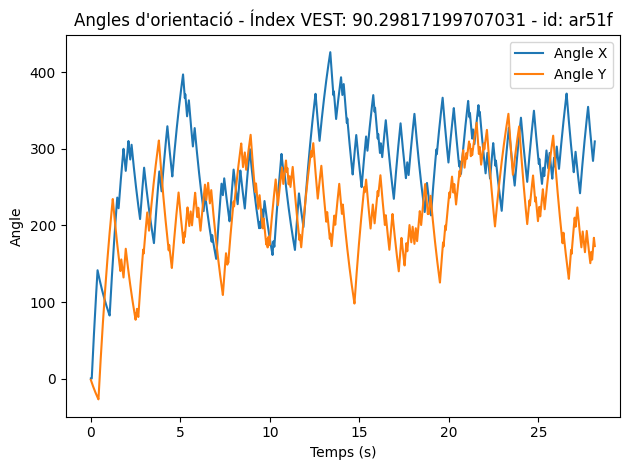

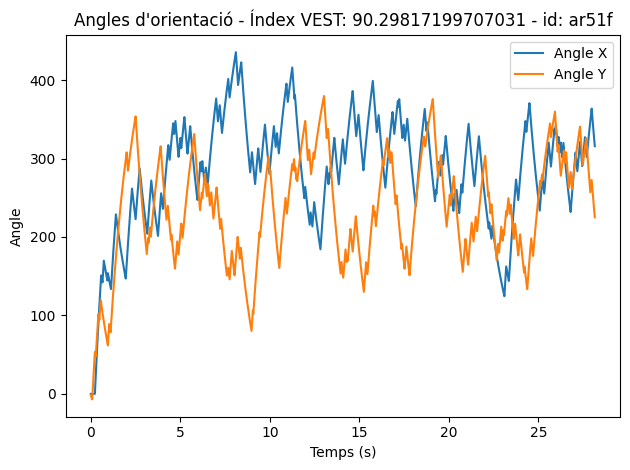

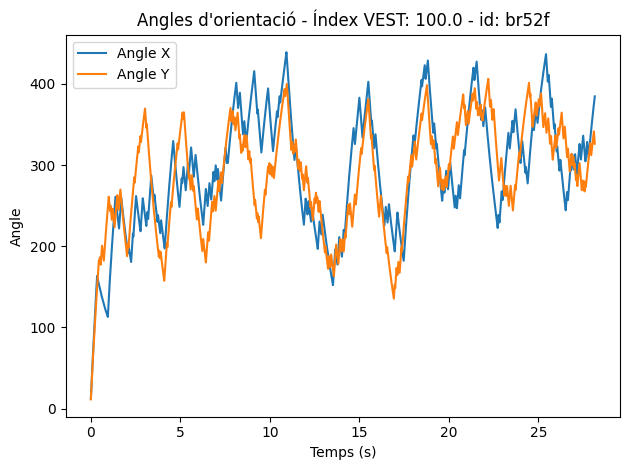

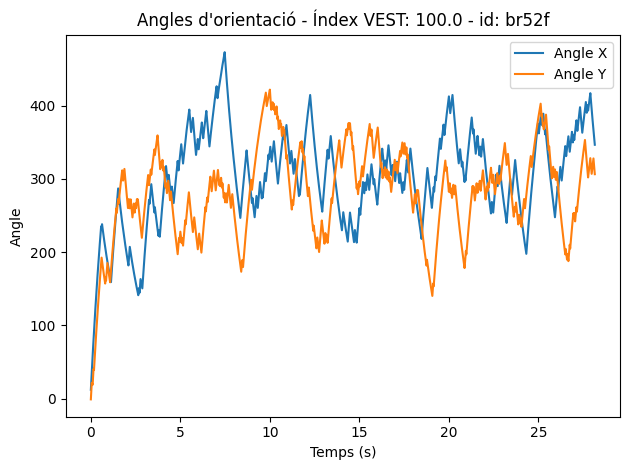

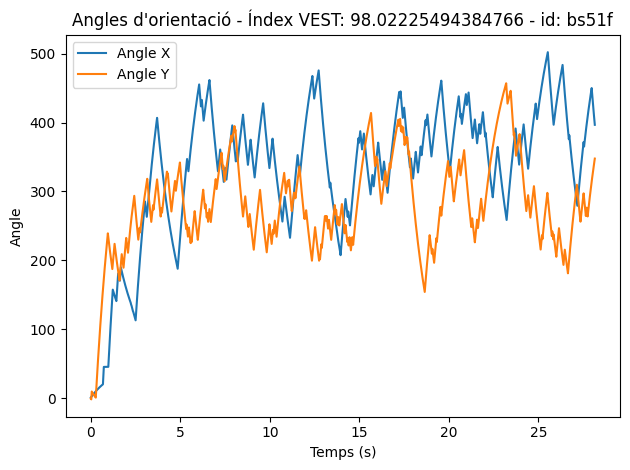

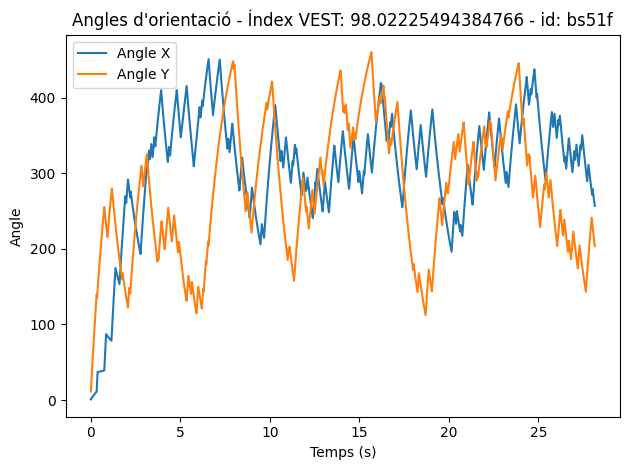

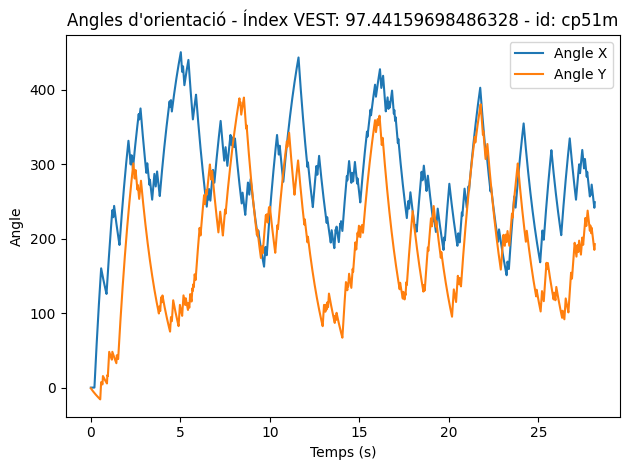

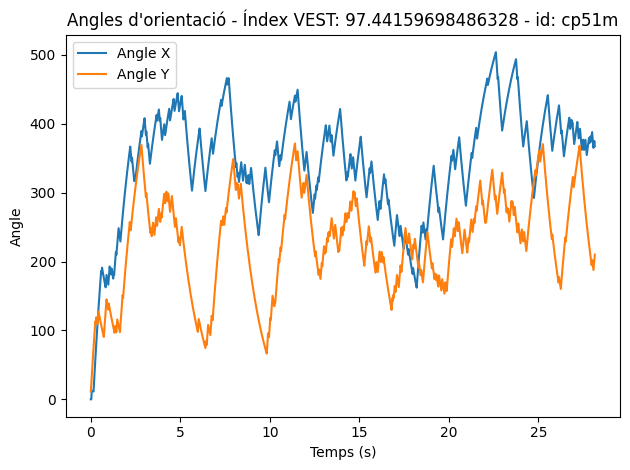

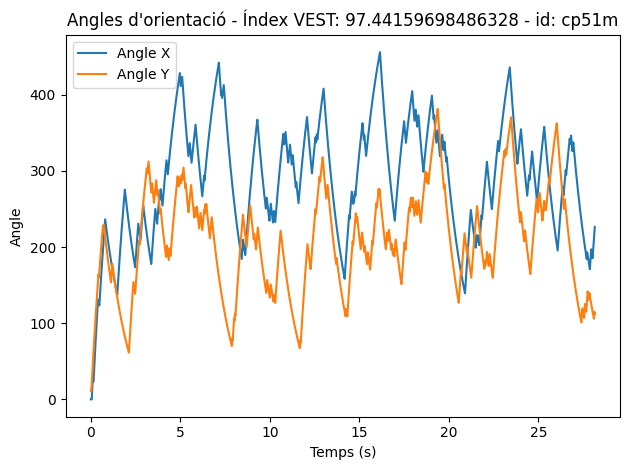

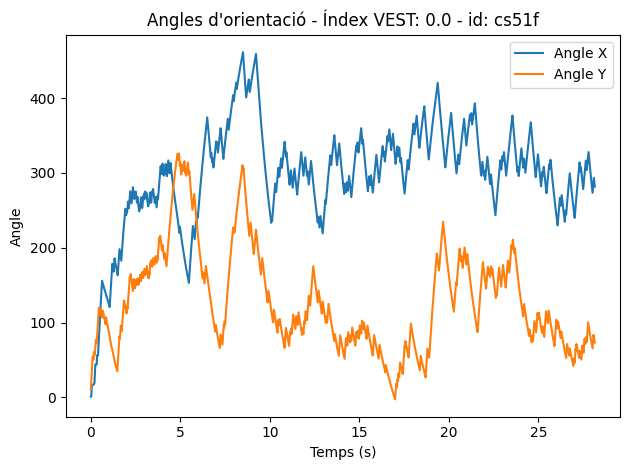

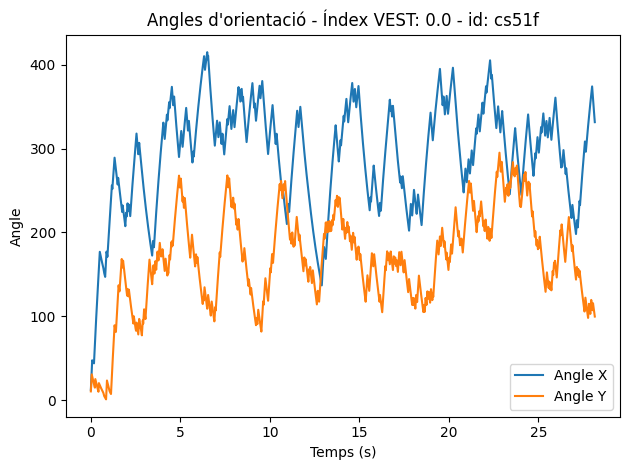

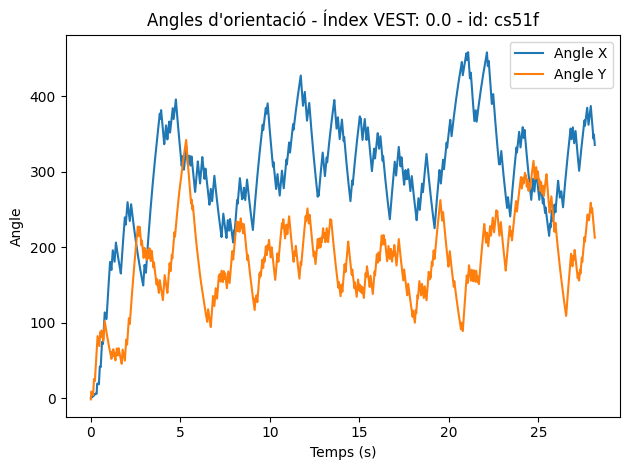

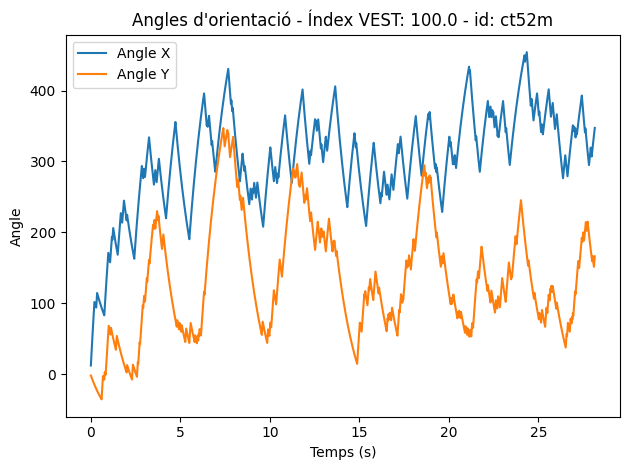

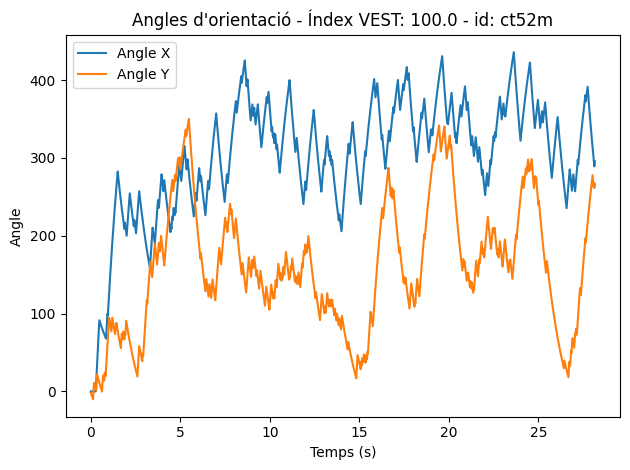

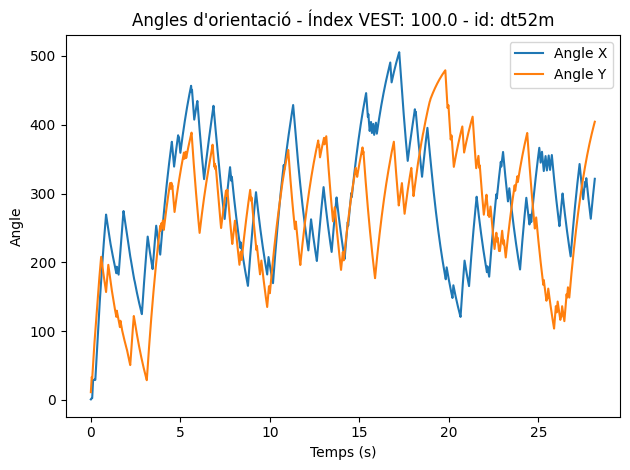

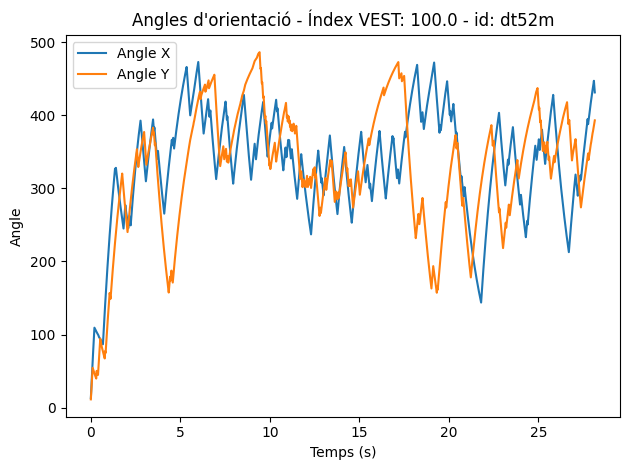

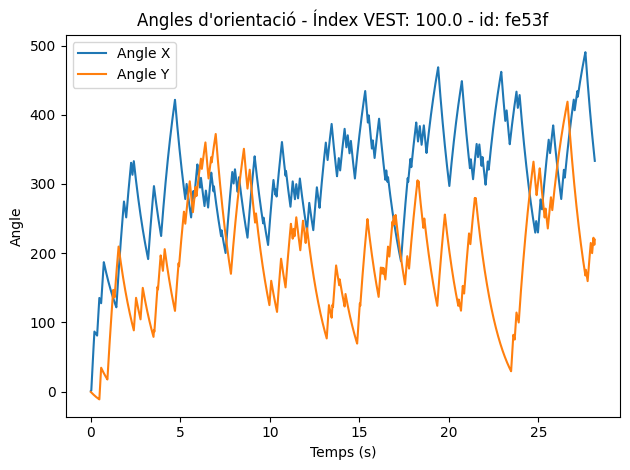

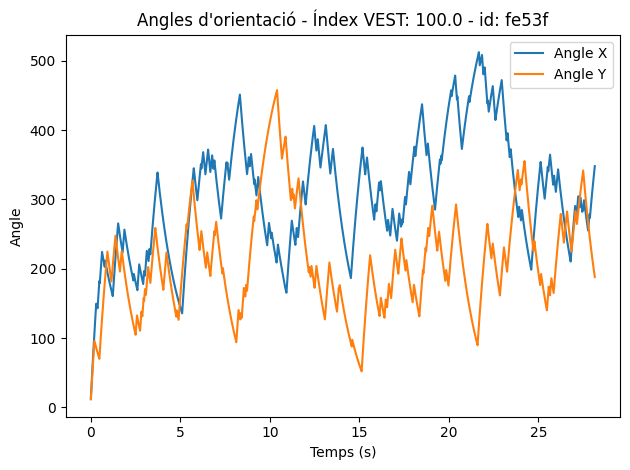

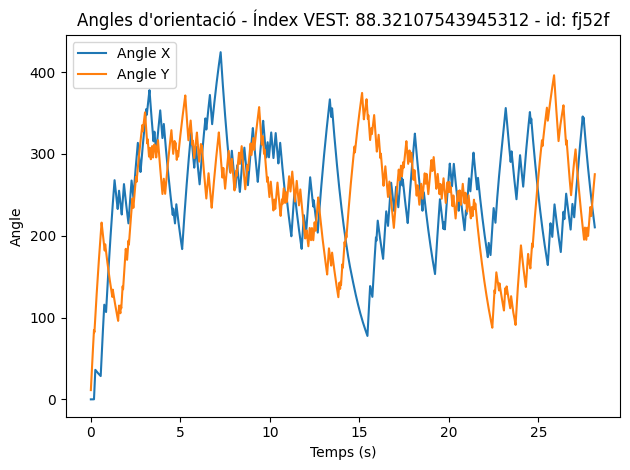

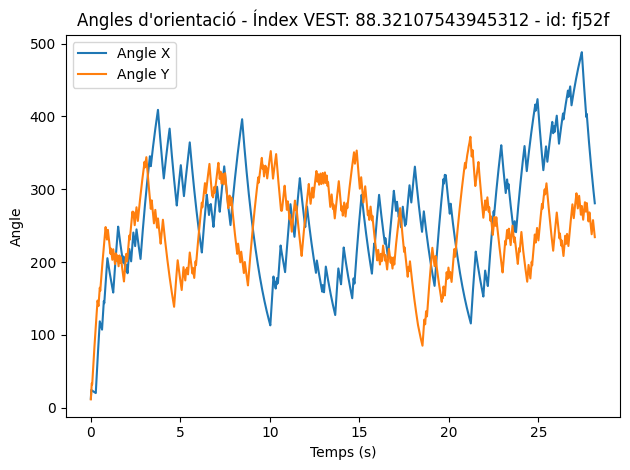

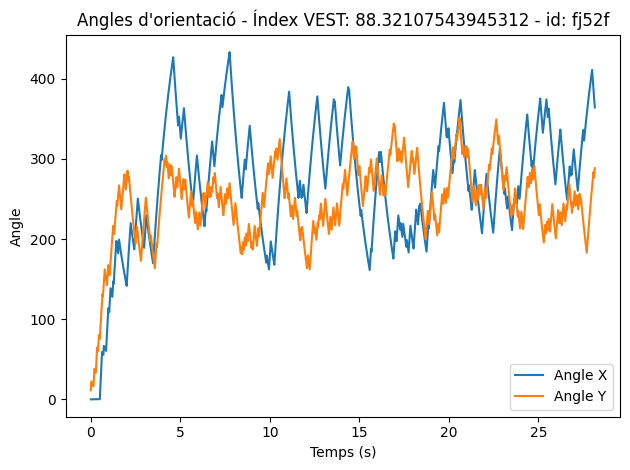

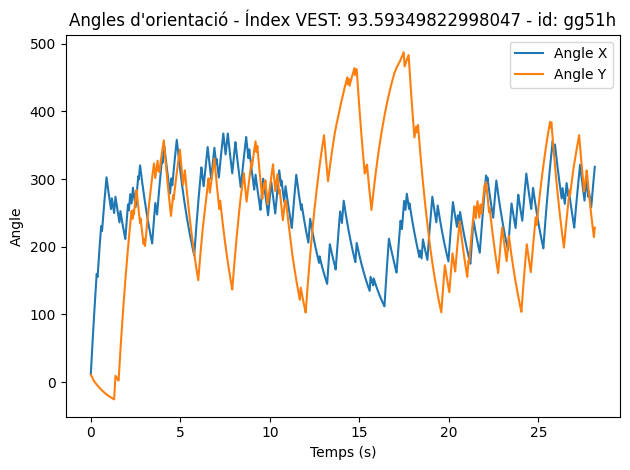

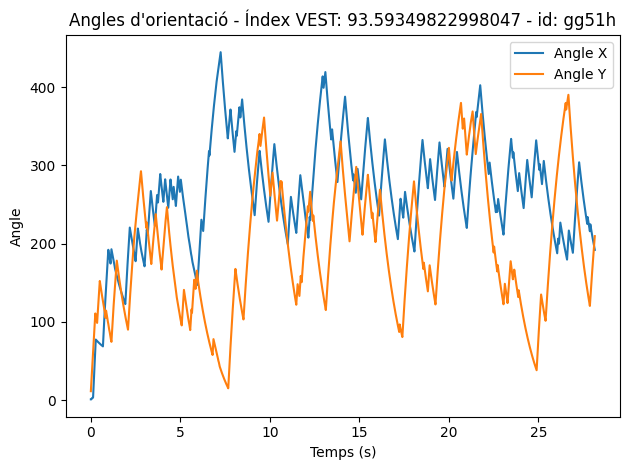

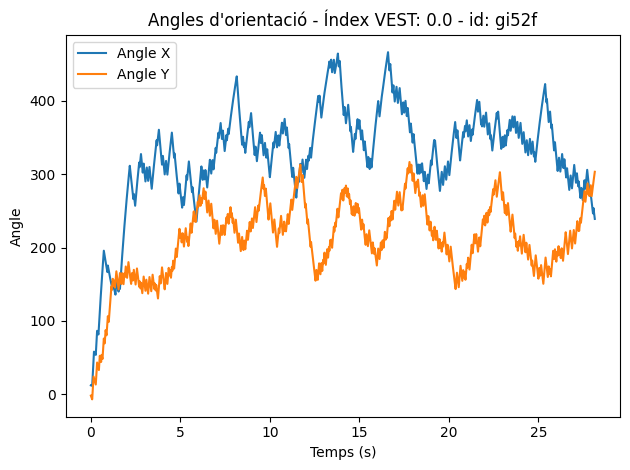

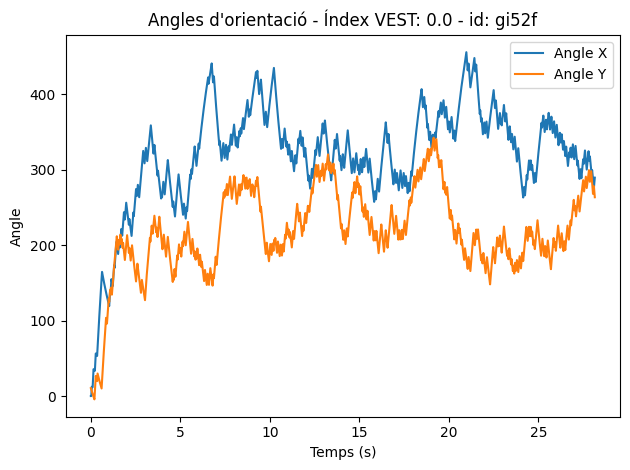

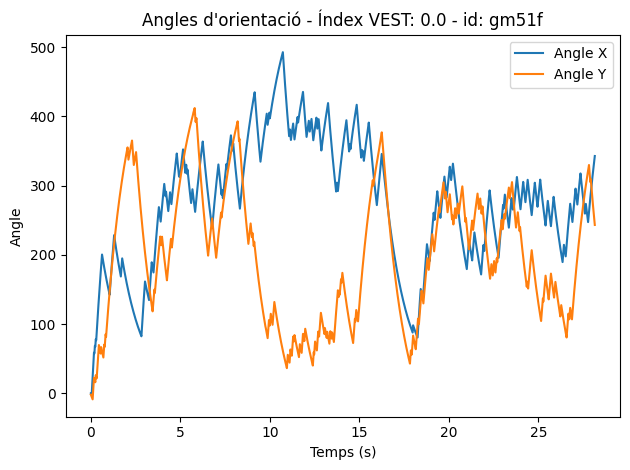

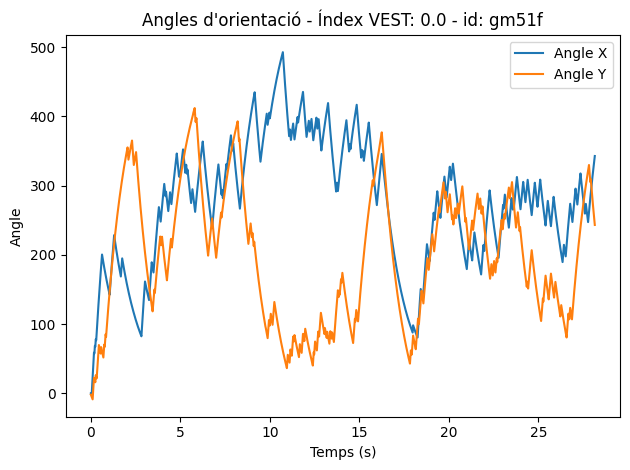

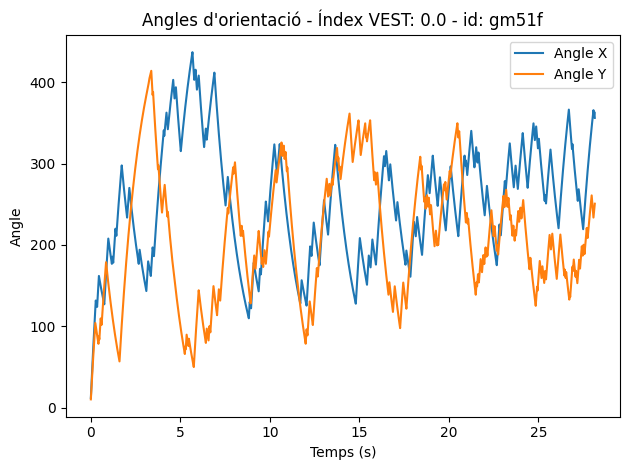

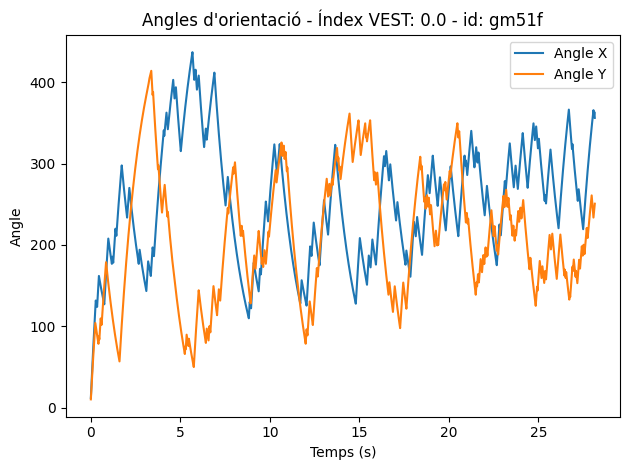

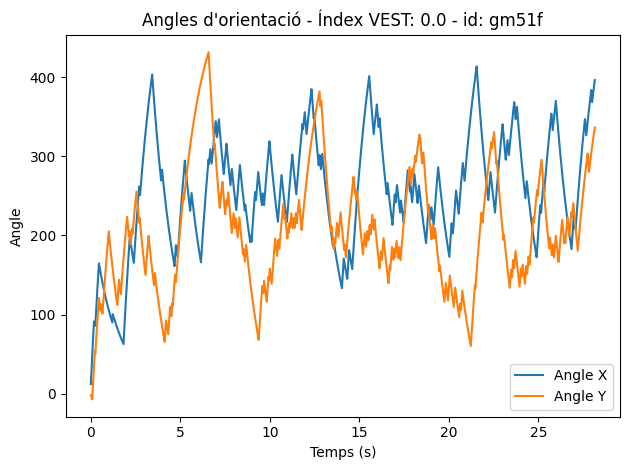

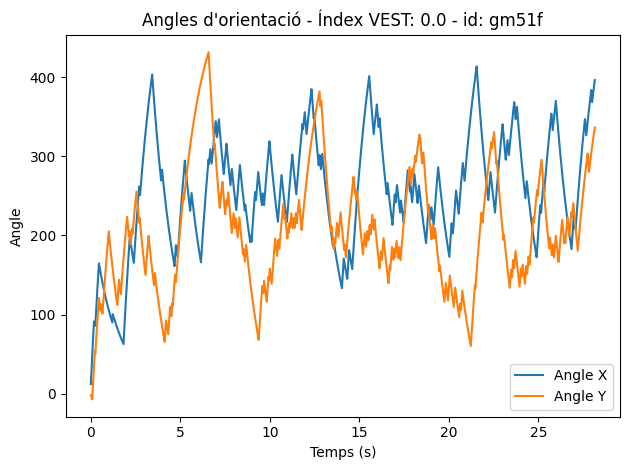

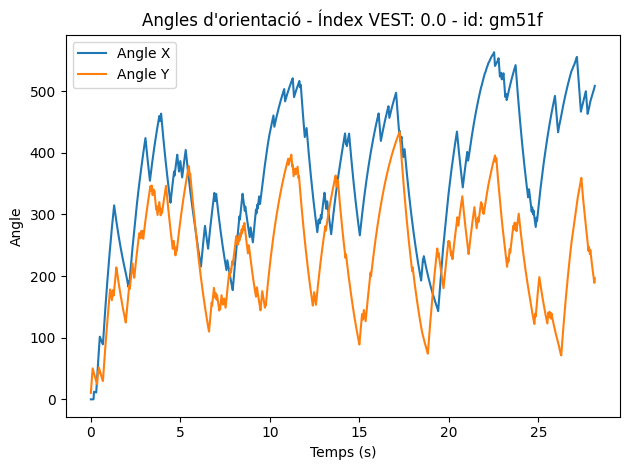

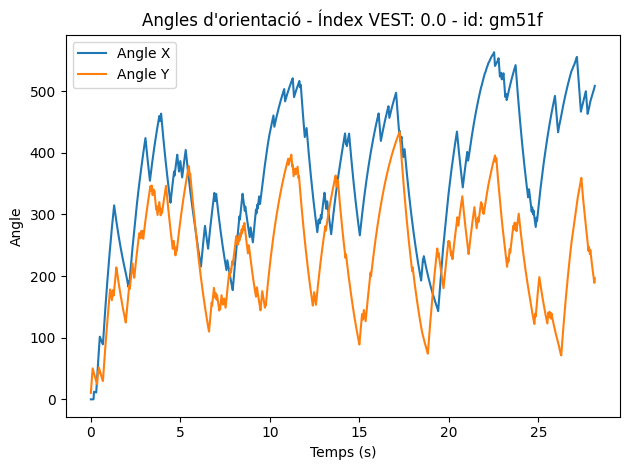

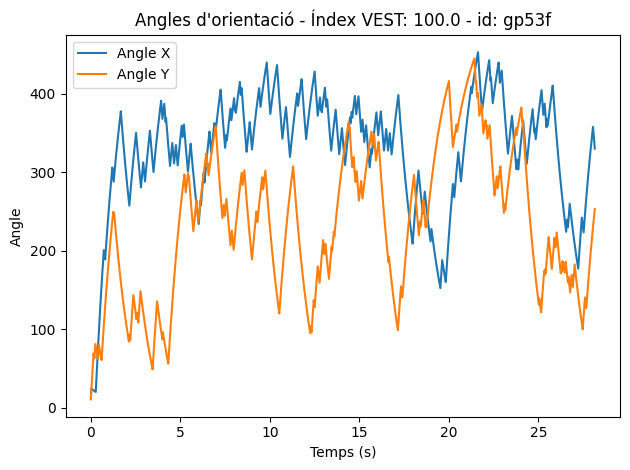

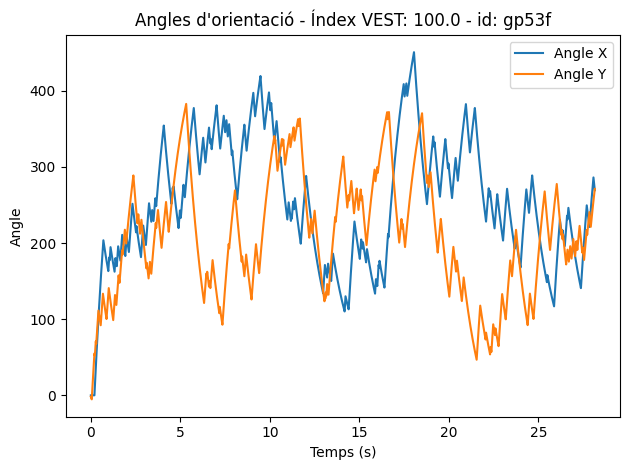

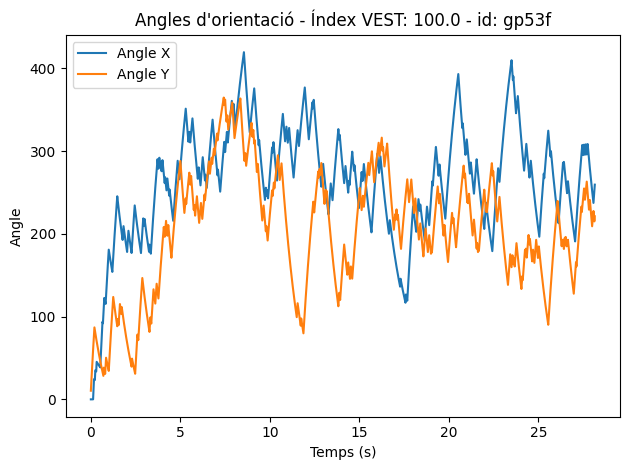

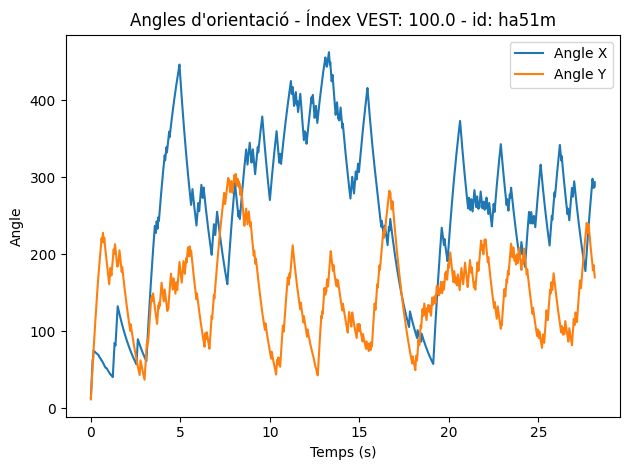

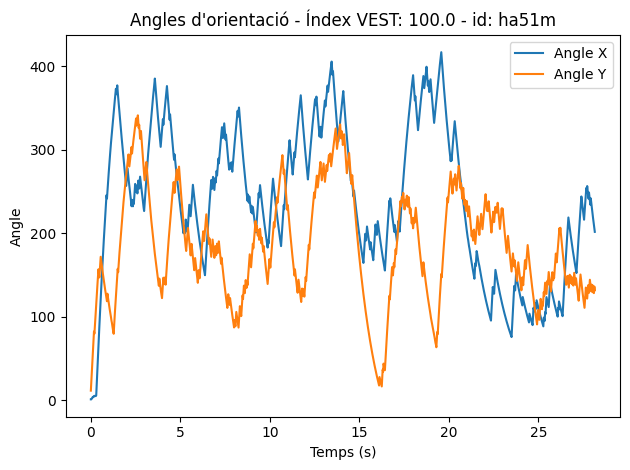

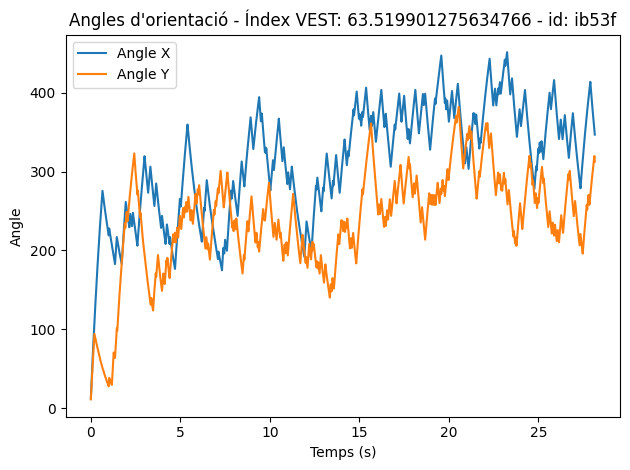

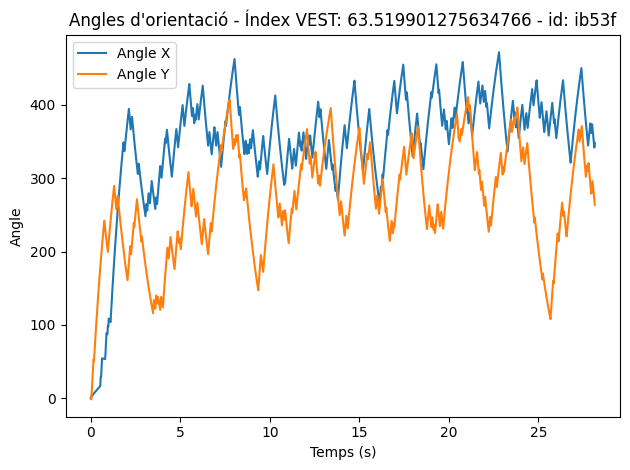

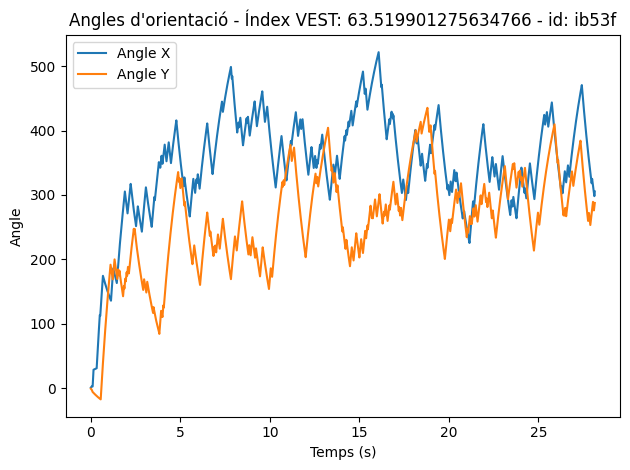

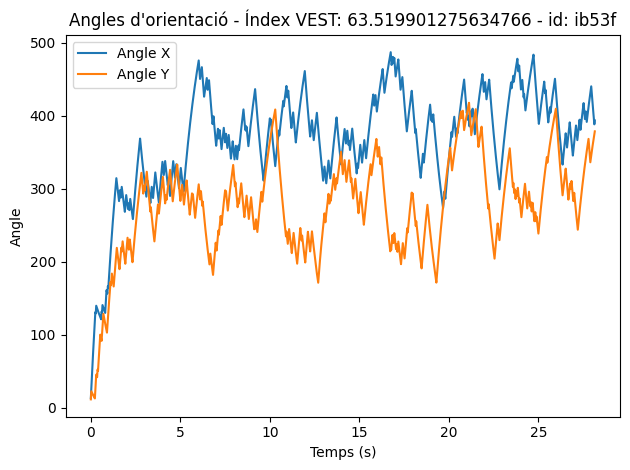

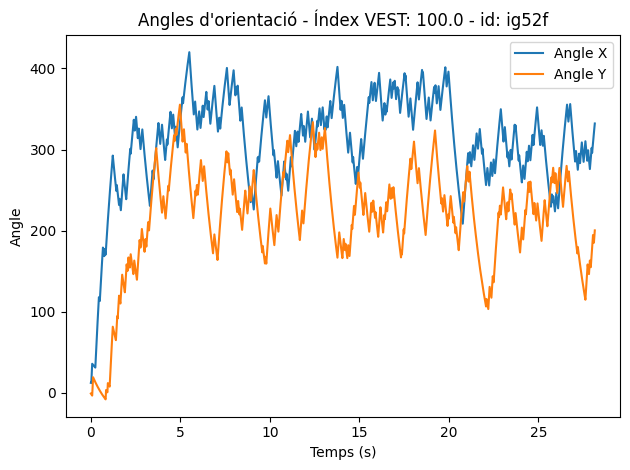

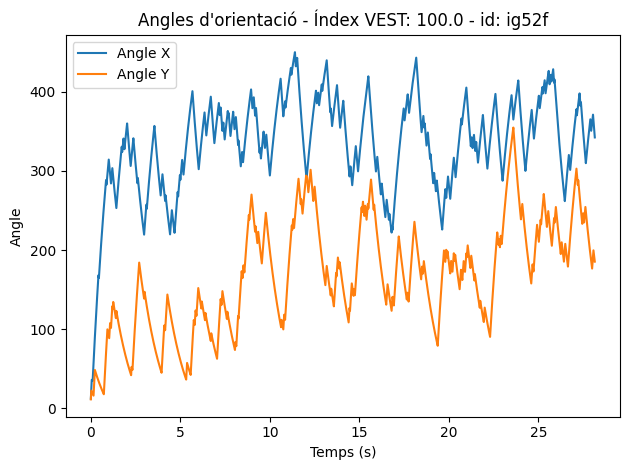

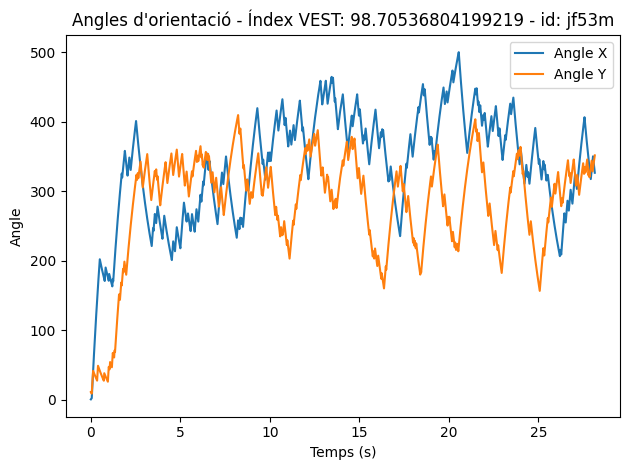

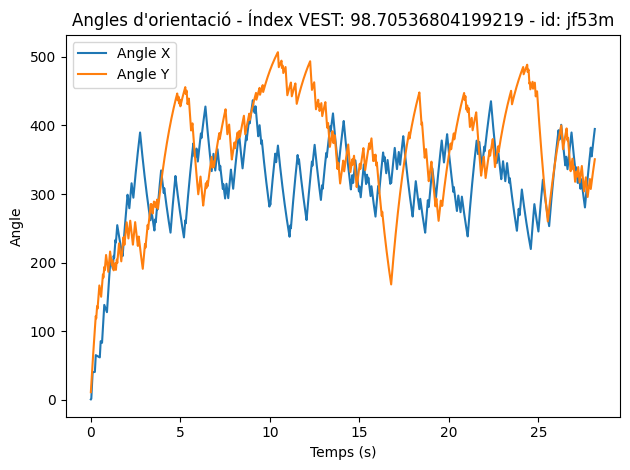

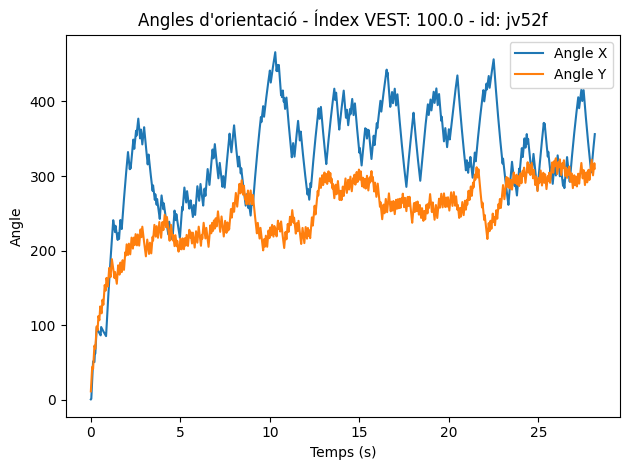

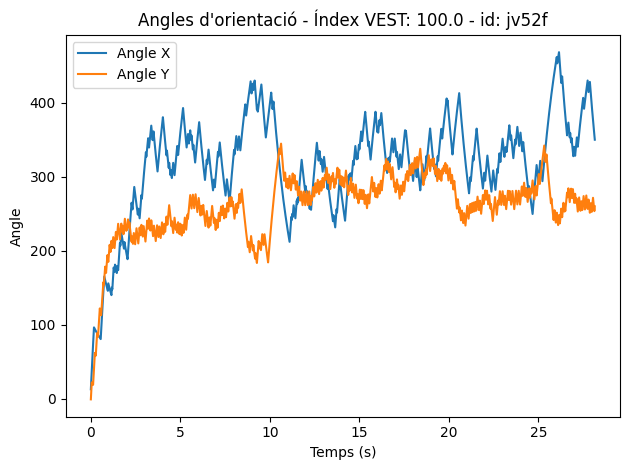

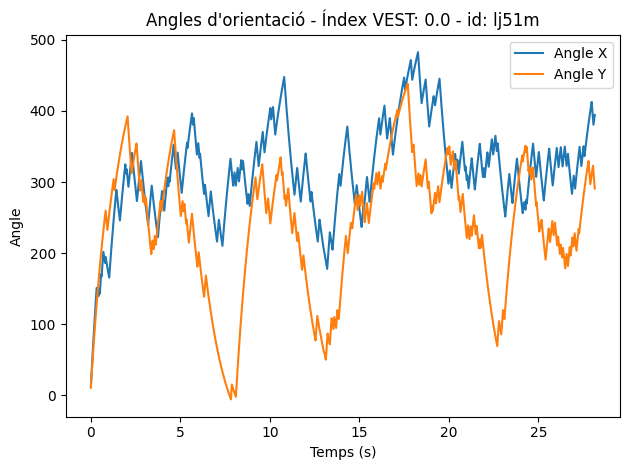

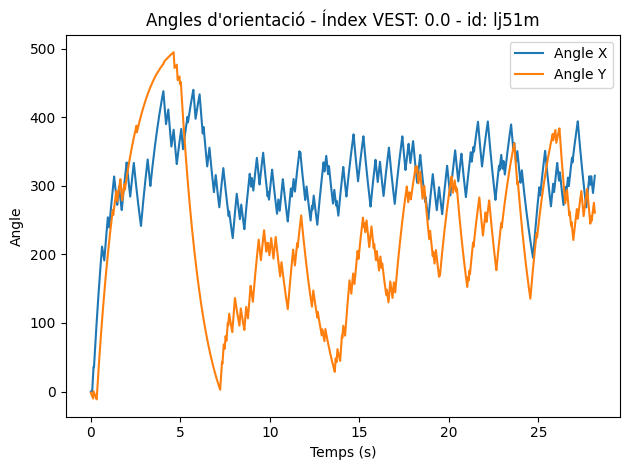

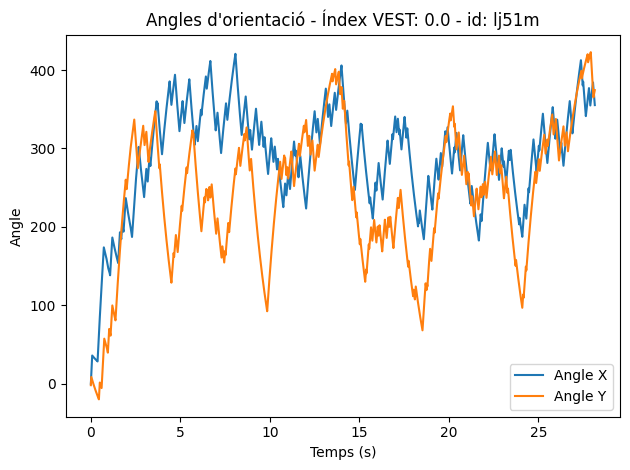

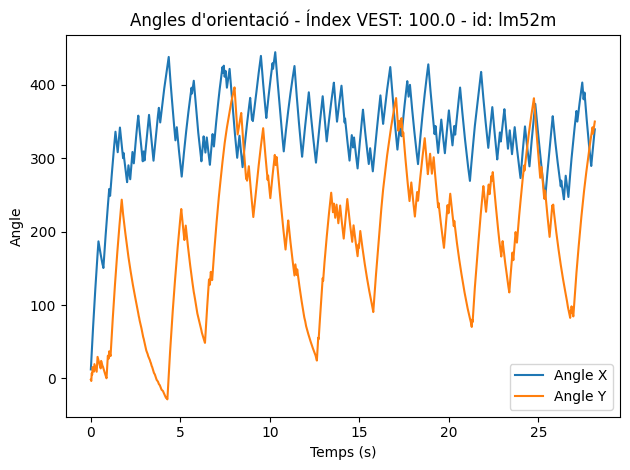

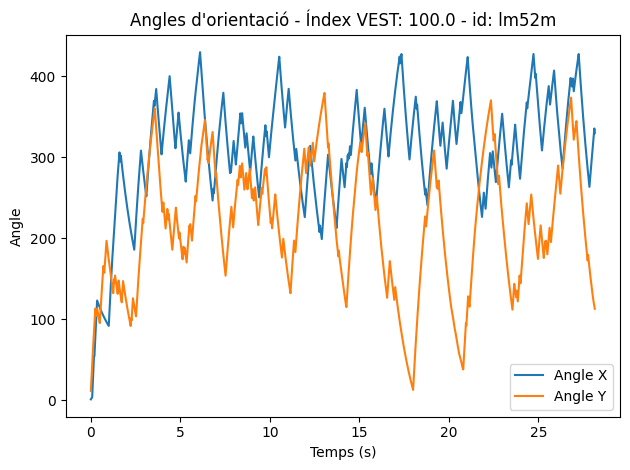

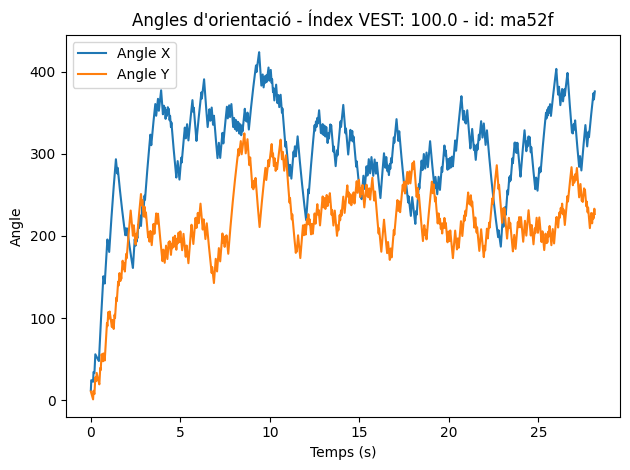

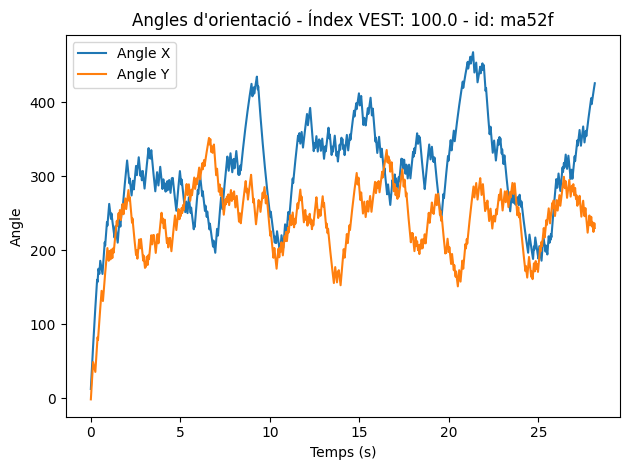

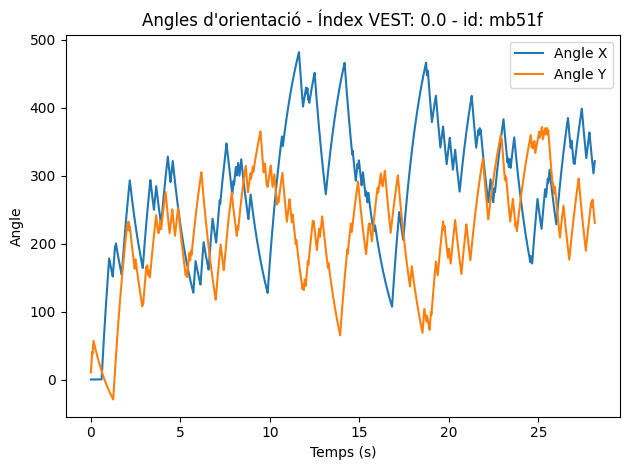

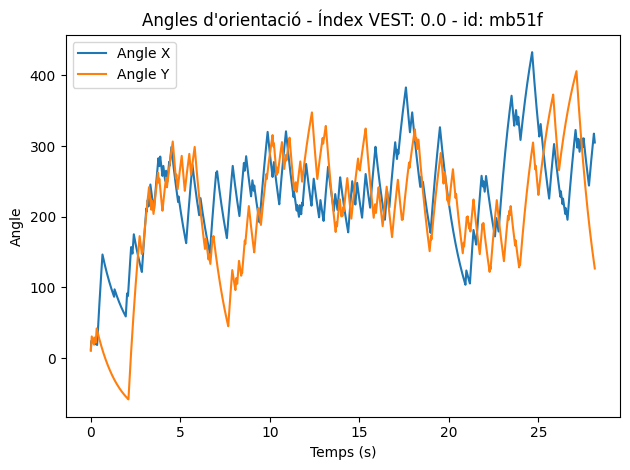

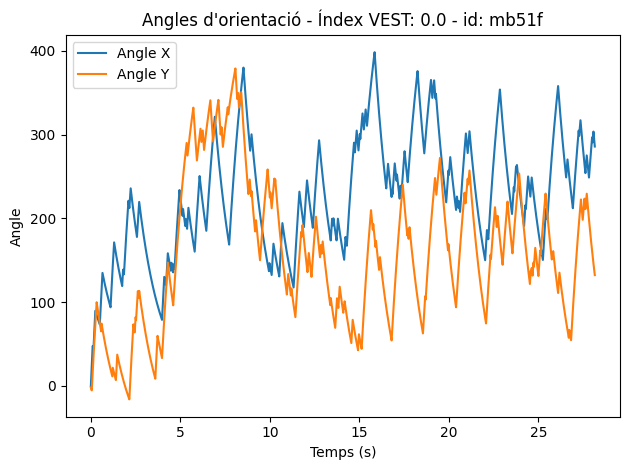

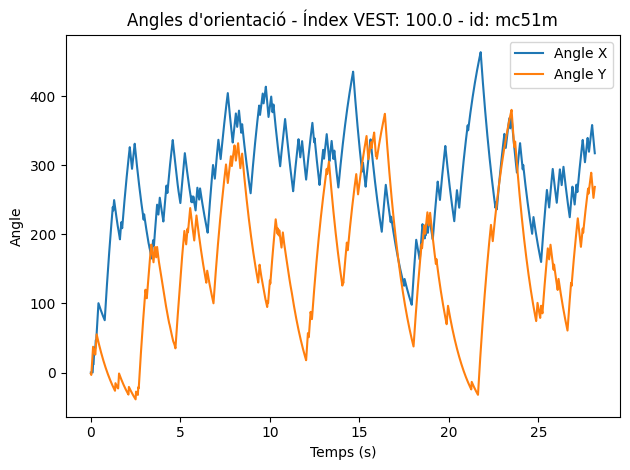

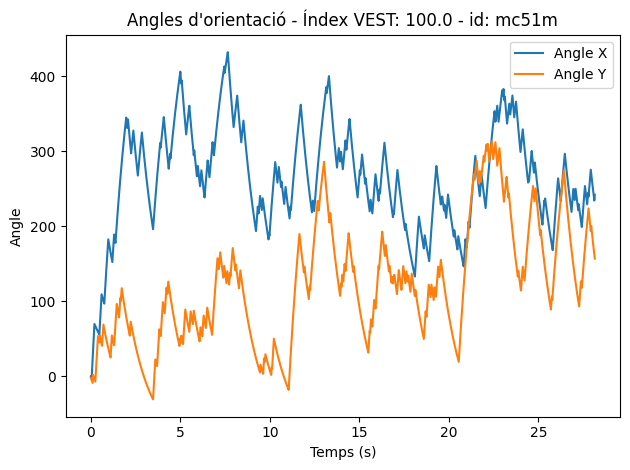

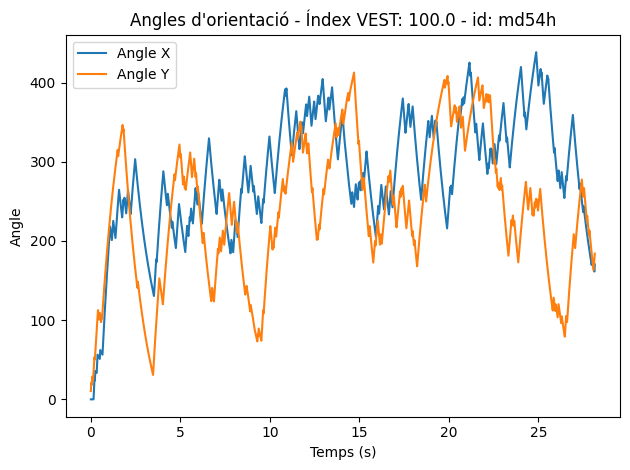

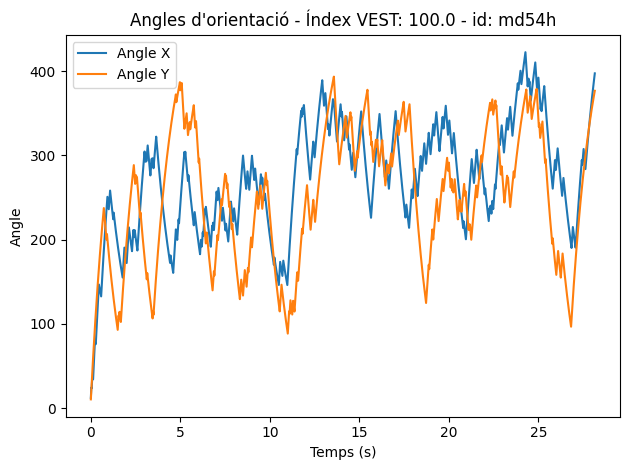

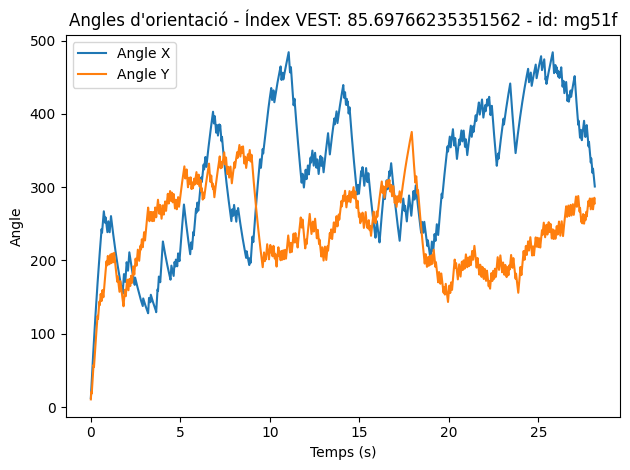

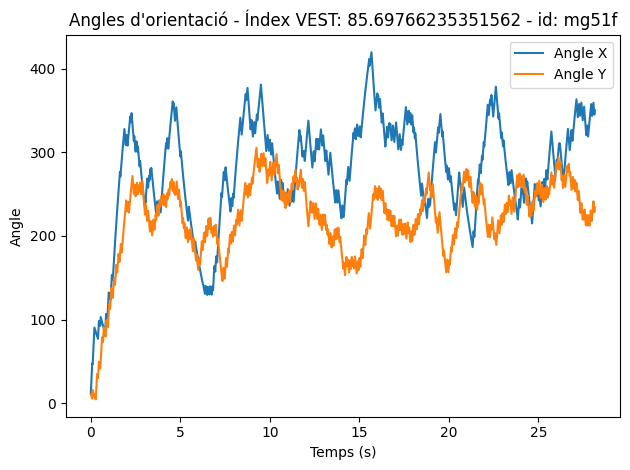

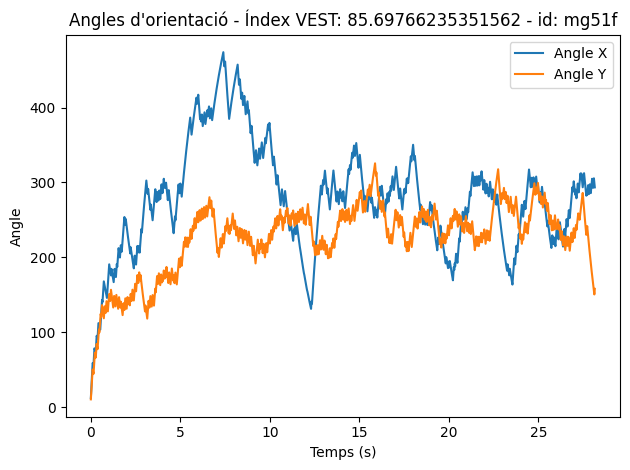

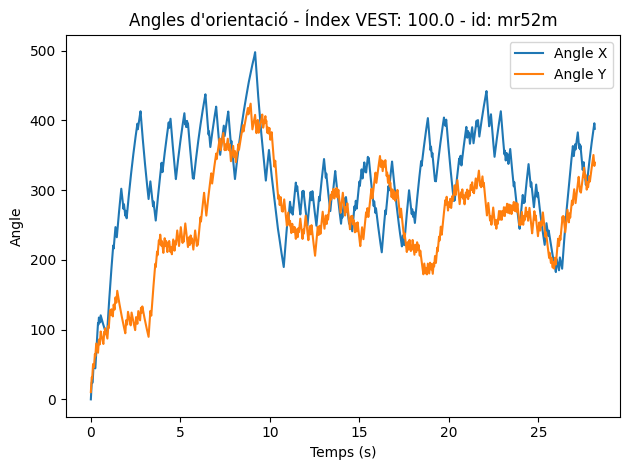

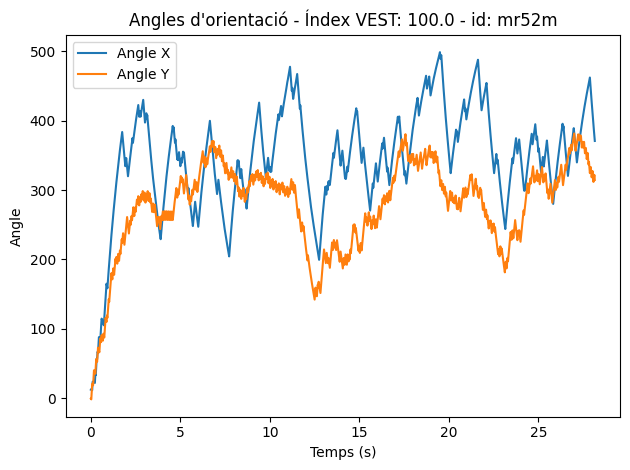

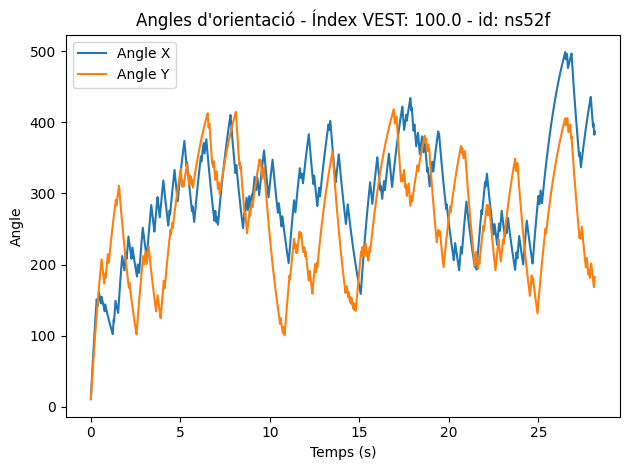

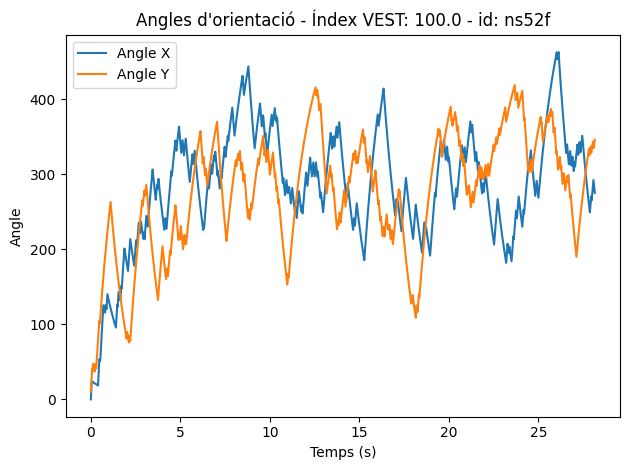

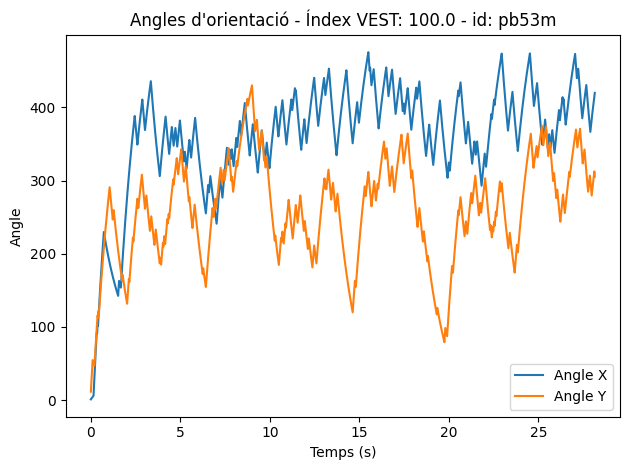

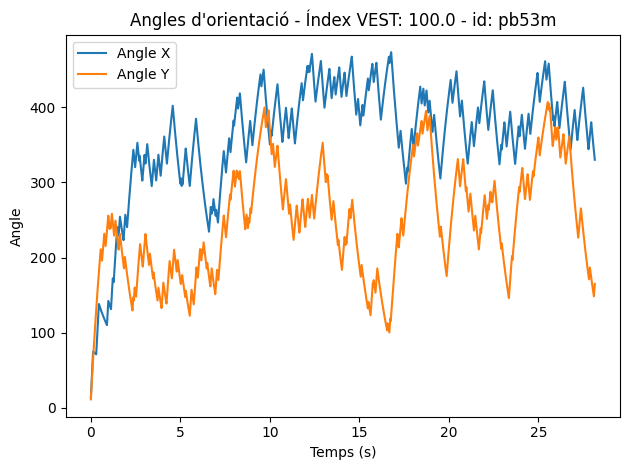

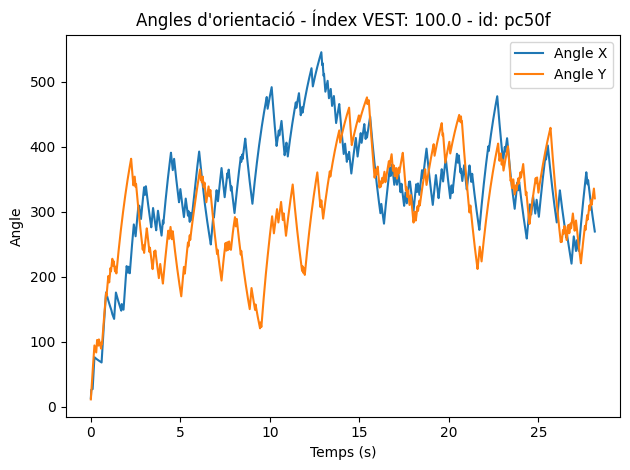

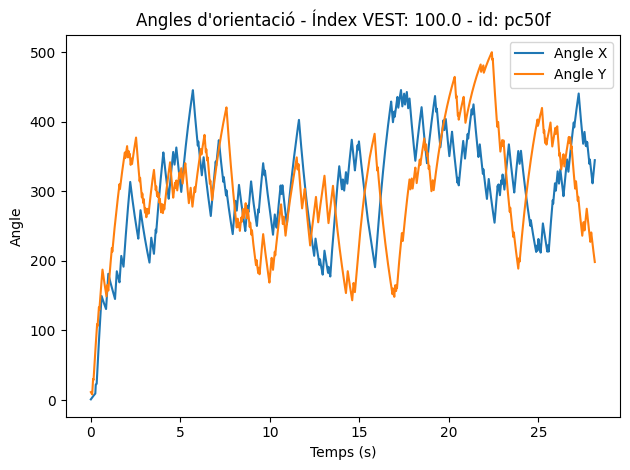

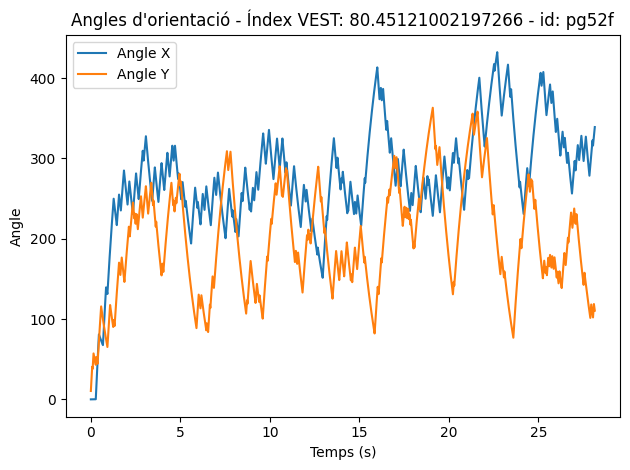

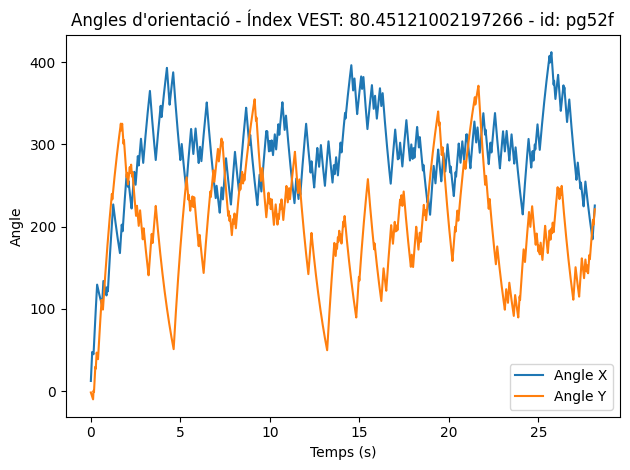

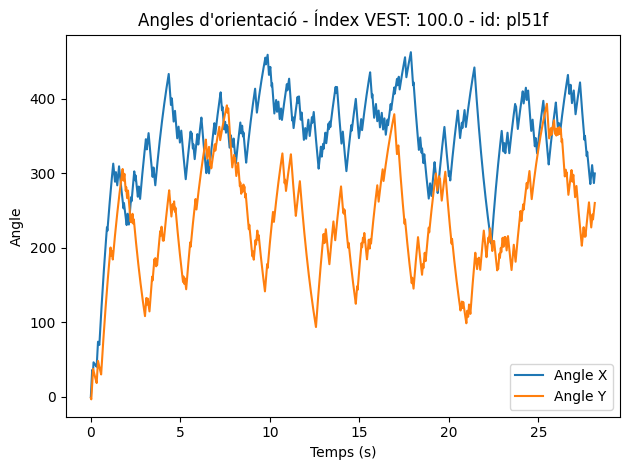

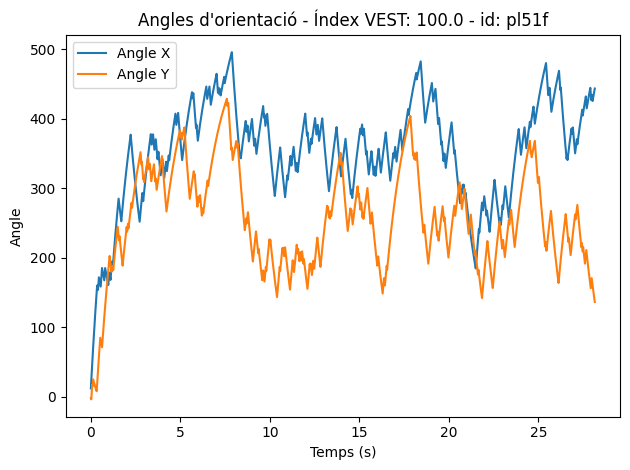

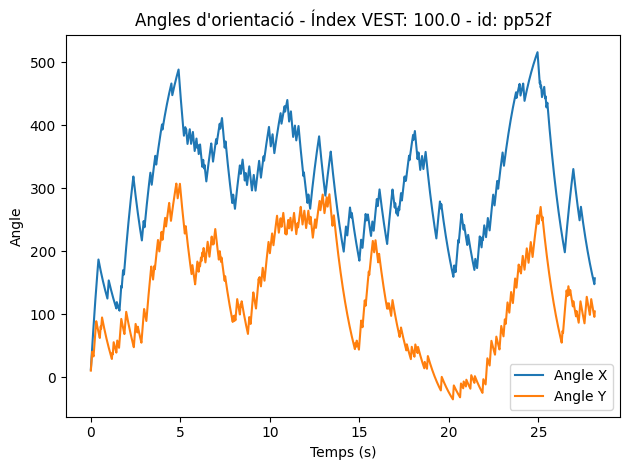

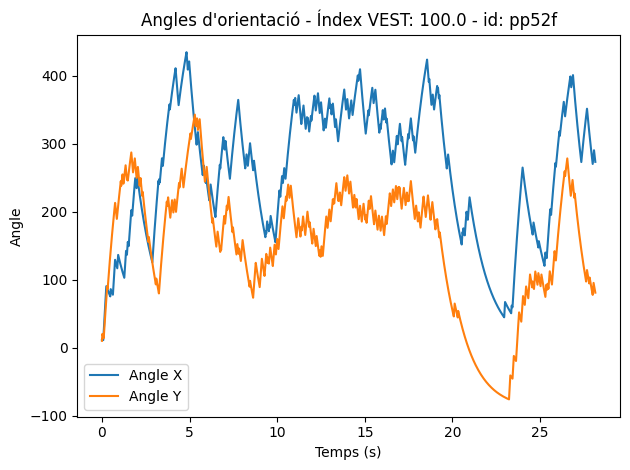

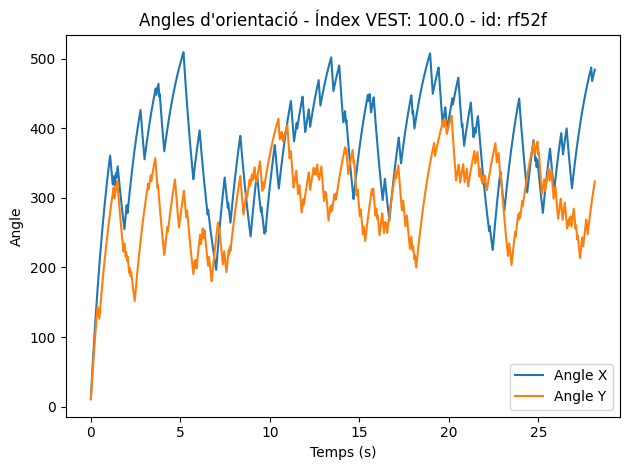

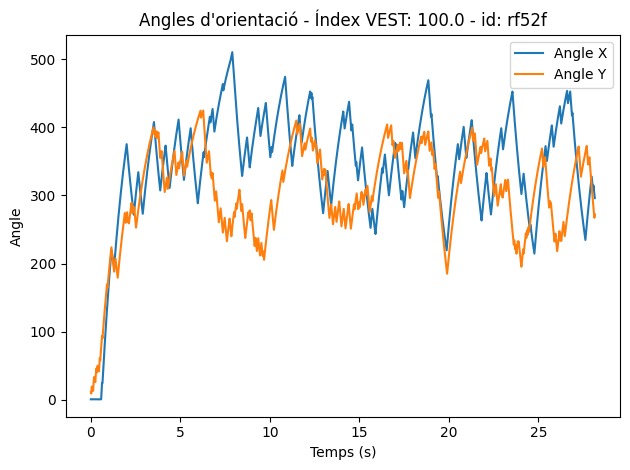

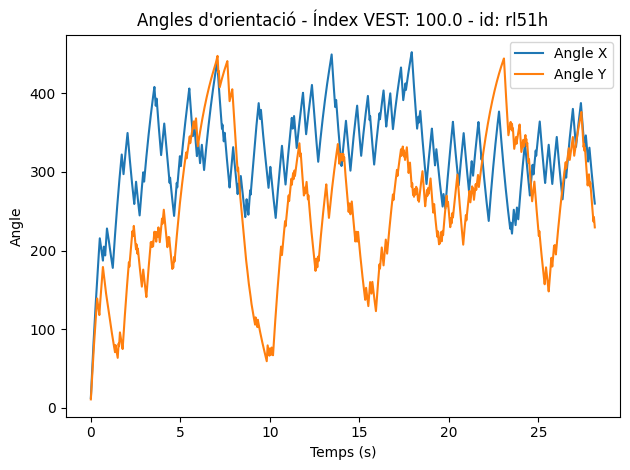

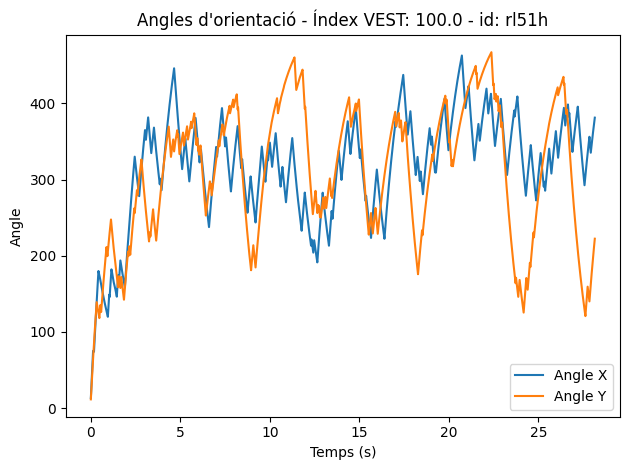

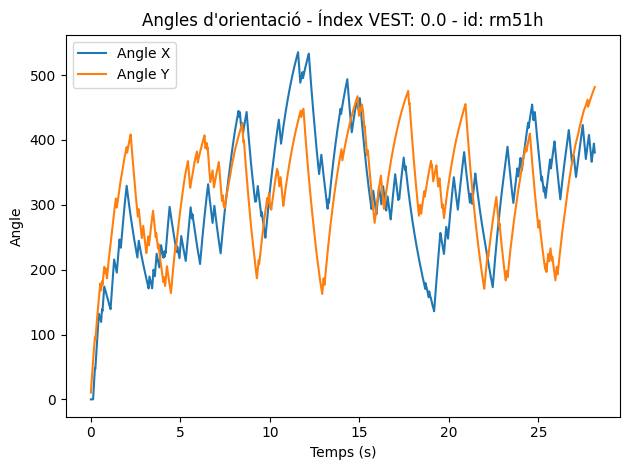

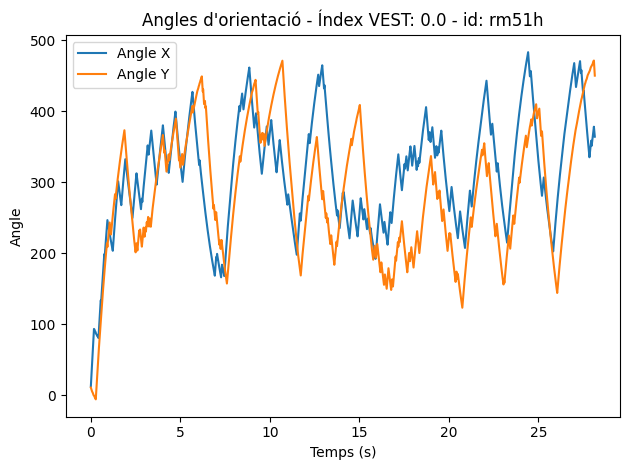

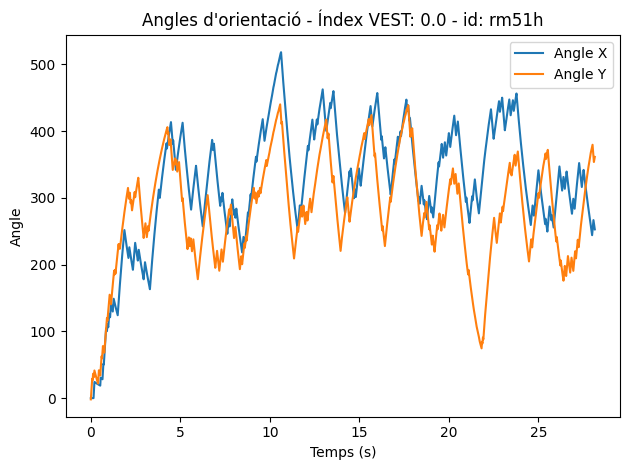

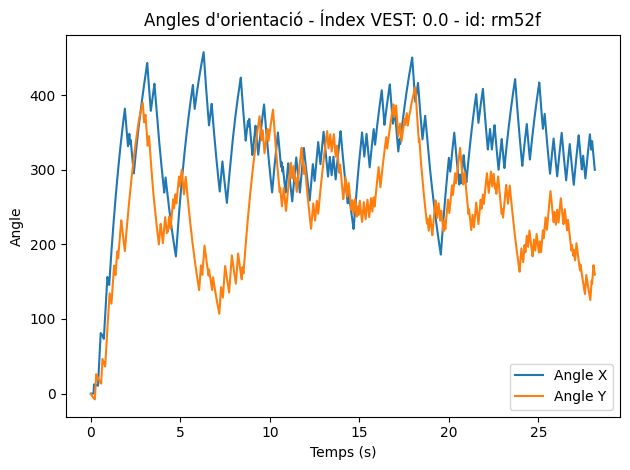

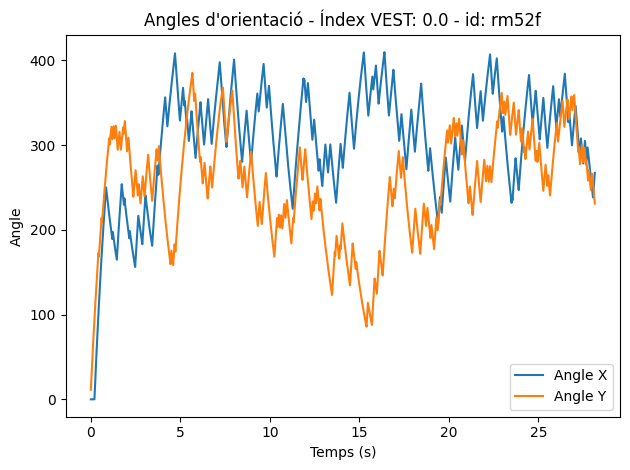

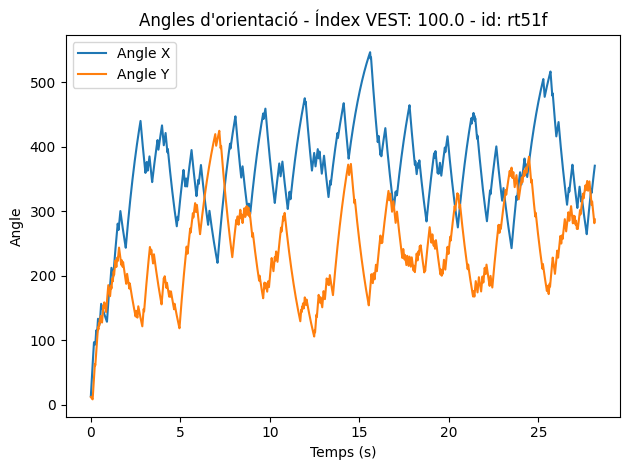

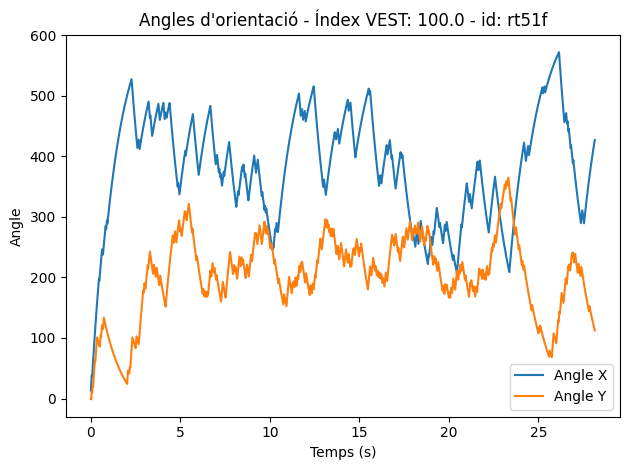

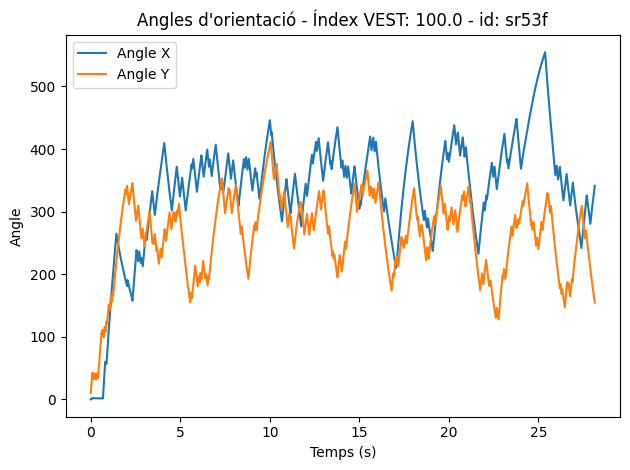

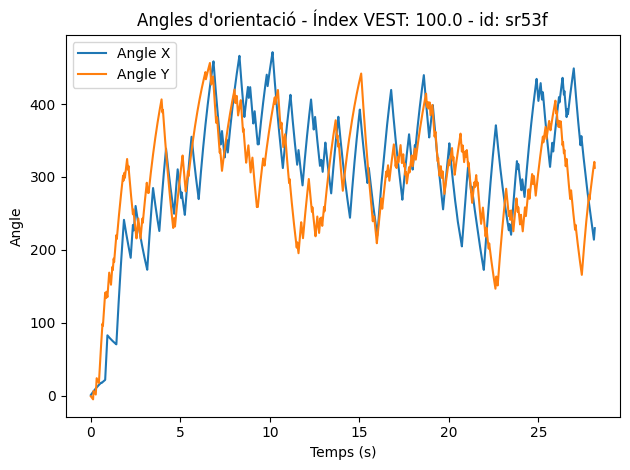

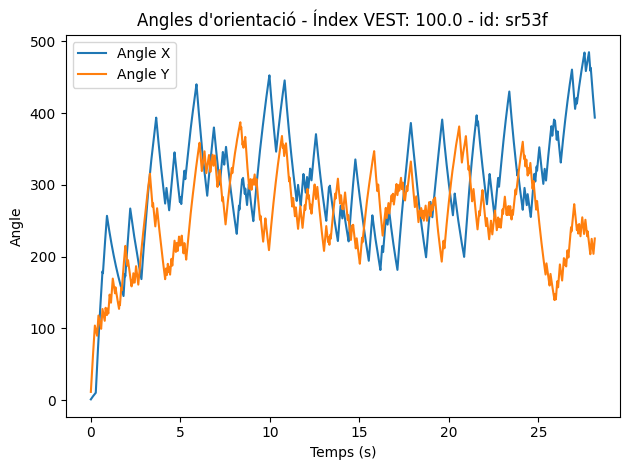

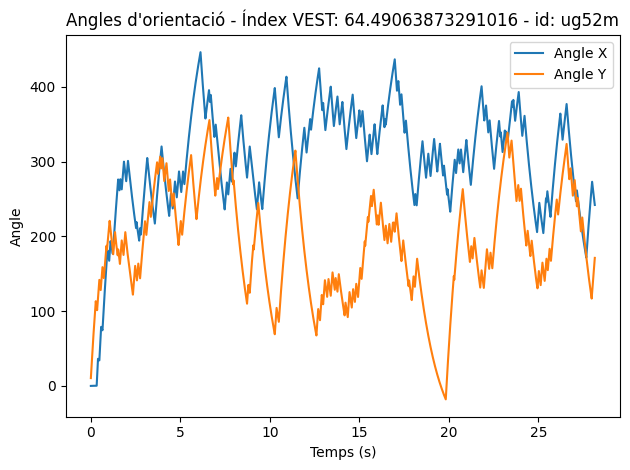

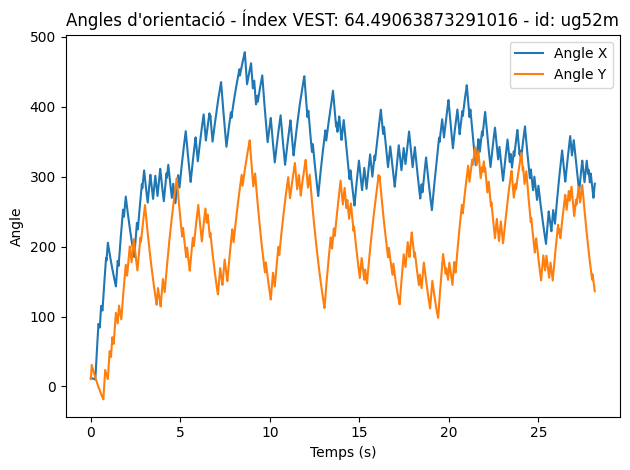

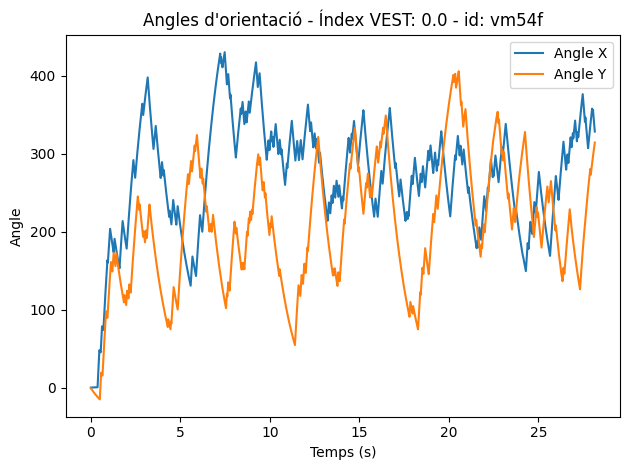

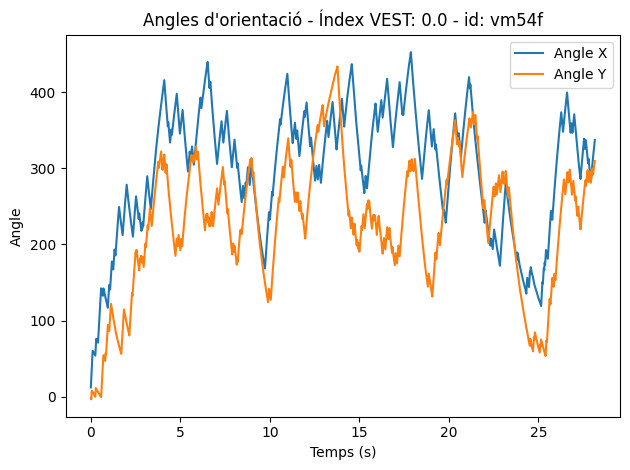

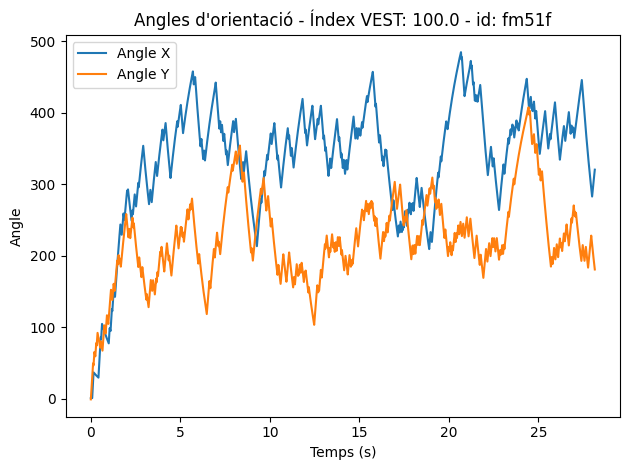

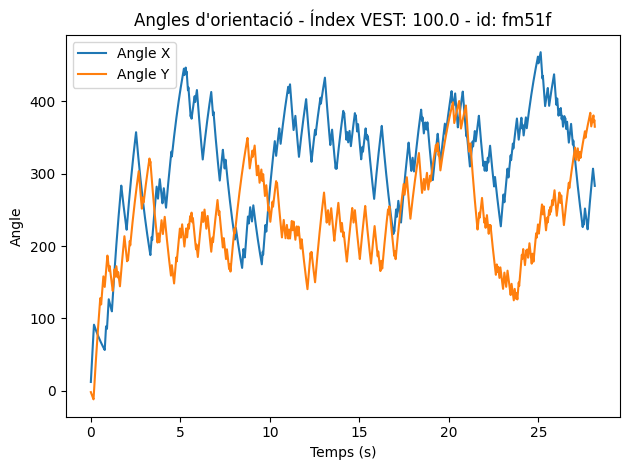

In [37]:
import math
import matplotlib.pyplot as plt


ids = dataRGC['id']
ids = ids.reset_index(drop=True)

X = dataRGC.drop(columns = ['id','action','rep','time','Indice_VIS','Indice_VEST','Indice_SOM'])
X = X.reset_index(drop=True)

Índex_VEST = dataRGC['Indice_VEST'].astype(float)/100
label = Índex_VEST.astype(np.float32)
label = label.reset_index(drop=True)
label = label*100

for i in range(X.shape[0]):
  ax = [int(elemento) for elemento in X.loc[i, 'acelerometro_x']]
  ay = [int(elemento) for elemento in X.loc[i, 'acelerometro_y']]
  az = [int(elemento) for elemento in X.loc[i, 'acelerometro_z']]

  gx = [int(elemento) for elemento in X.loc[i, 'giroscopo_x']]
  gy = [int(elemento) for elemento in X.loc[i, 'giroscopo_y']]
  gz = [int(elemento) for elemento in X.loc[i, 'giroscopo_z']]

  #Inicialització angles previs
  ang_x_prev = 0.0
  ang_y_prev = 0.0
  dt = 0.025

  ang_x = list(range(len(ax)))
  ang_y = list(range(len(ax)))

  for j in range(len(ax)):

    #Càlcul angles amb l'acceleròmetre
    accel_ang_x = math.atan(ay[j] / math.sqrt(math.pow(ax[j], 2) + math.pow(az[j], 2)))*(180.0 / math.pi)

    #gestió denominador ja que en alguns casos és = 0
    denominador = math.sqrt(math.pow(ay[j], 2) + math.pow(az[j], 2))
    if denominador != 0:
        accel_ang_y = math.atan(-ax[j] / denominador) * (180.0 / math.pi)
    else:
        accel_ang_y = ang_y_prev #en cas que el denominador sigui zero li adjudiquem el valor de l'angle anterior

    #Actualitzar els angles amb el giròscop i el filtre complementari
    ang_x[j] = 0.98*(ang_x_prev + (gx[j] / 131)*dt) + 0.02*accel_ang_x
    ang_y[j] = 0.98*(ang_y_prev + (gy[j] / 131)*dt) + 0.02*accel_ang_y

    ang_x_prev = ang_x[j]
    ang_y_prev = ang_y[j]


  temps = np.arange(0, 1127) * 0.025 #1150 roa, 1127 rgc

  plt.figure()
  plt.plot(temps, ang_x, label='Angle X')
  plt.plot(temps, ang_y, label='Angle Y')
  plt.xlabel('Temps (s)')
  plt.ylabel('Angle')
  titol = 'Angles d\'orientació - Índex VEST: {} - id: {}'.format(label[i], ids[i])
  plt.title(titol)
  plt.legend()

  plt.tight_layout()

  nombre_archivo = "or_{}.png".format(i)
  if label[i]<0.5:

    ruta_archivo = '/content/drive/My Drive/graf_orientation/rgc_pos/' + nombre_archivo
  else:

    ruta_archivo = '/content/drive/My Drive/graf_orientation/rgc_neg/' + nombre_archivo


  plt.savefig(ruta_archivo)


In [ ]:
X_3d = np.empty((X.shape[0], X.shape[1], len(X.values[0][0])), dtype=object)  # ndarray de forma (78, 12, 1150) con elementos vacíos
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        X_3d[i, j] = tf.constant(X.values[i][j])

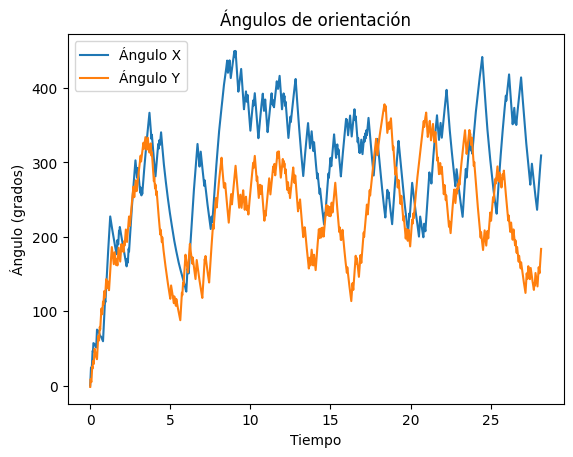

In [ ]:
import matplotlib.pyplot as plt

# Crear una lista de tiempo en función de la frecuencia de muestreo
tiempo = [i * dt for i in range(len(ax))]

# Graficar los ángulos
plt.figure()
plt.plot(tiempo, ang_x, label='Ángulo X')
plt.plot(tiempo, ang_y, label='Ángulo Y')
plt.xlabel('Tiempo')
plt.ylabel('Ángulo (grados)')
plt.title('Ángulos de orientación')
plt.legend()
plt.show()


In [ ]:
ang_x

[0.00043573312662119335,
 12.253525894094992,
 24.261999334035593,
 23.784079467112942,
 23.311754903442967,
 35.09840453107984,
 46.65042555460605,
 45.718030334381936,
 57.050329334106294,
 56.819913294814256,
 55.68719274397053,
 55.4822322871741,
 54.3770667880758,
 53.30008667231175,
 52.23883059066622,
 51.20112436481242,
 63.341147722886646,
 75.23841550500224,
 74.6529225887489,
 74.0810133461636,
 73.54059677780033,
 72.11358373326463,
 70.71234959239078,
 69.32835461103875,
 67.95441398478339,
 66.61678839408984,
 66.21981185416668,
 65.82871005545893,
 64.53427557487208,
 63.270253888867614,
 62.034344163966395,
 60.80208170965054,
 59.58724163635241,
 70.6478654316533,
 82.39454600576535,
 93.90856756375484,
 104.28303228957814,
 114.45297299661858,
 112.1656677973814,
 123.078197723656,
 132.86567147969686,
 142.44651284327128,
 152.74625698558881,
 162.84553045302133,
 172.73817218271378,
 182.43364451139502,
 191.0404485786892,
 200.3831772521878,
 209.53132524845353,
 2

In [ ]:
#funcio que redimensiona les dades a 2d per poder aplicar minmaxscaler, NORM PER CARACTERÍSTIQUES
class MinMaxScaler3D(MinMaxScaler):
    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

In [ ]:
scaler = MinMaxScaler3D()
X_3d = scaler.fit_transform(X_3d)

In [ ]:
X_train = X_3d[:90].astype(np.float32)
y_train = Índex_SOM[:90].astype(np.float32)
y_Train = y_train.values
X_test = X_3d[90:].astype(np.float32)
y_test = Índex_SOM[90:].astype(np.float32)
y_test = y_test.values
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Començem per crear una LSTM per a les dades de l'accelerómetre

In [ ]:
accelerometre_train, accelerometre_test = X_train[:, :3, :], X_test[:, :3, :]
accelerometre_train = accelerometre_train.transpose((0, 2, 1))
accelerometre_test = accelerometre_test.transpose((0,2,1))
print(accelerometre_train.shape, accelerometre_test.shape)


In [ ]:
giroscop_train, giroscop_test = X_train[:, 3:6, :], X_test[:, 3:6, :]
giroscop_train = giroscop_train.transpose((0, 2, 1))
giroscop_test = giroscop_test.transpose((0,2,1))
print(giroscop_train.shape, giroscop_test.shape)


In [ ]:
compass_train, compass_test = X_train[:, 6:9, :], X_test[:, 6:9, :]
compass_train = compass_train.transpose((0, 2, 1))
compass_test = compass_test.transpose((0,2,1))
print(compass_train.shape, compass_test.shape)


In [ ]:
gravity_train, gravity_test = X_train[:, 9:12, :], X_test[:, 9:12, :]
gravity_train = gravity_train.transpose((0, 2, 1))
gravity_test = gravity_test.transpose((0,2,1))
print(gravity_train.shape, gravity_test.shape)

In [ ]:
# Construir el modelo de LSTM
model_acc = Sequential()
model_acc.add(LSTM(64, input_shape=(1150, 3)))
model_acc.add(Dropout(0.30))
model_acc.add(Dense(1, activation='sigmoid'))
"""
# Compilar y entrenar el modelo
model_acc.compile(loss='mean_squared_error', optimizer='adam')
model_acc.fit(accelerometre_train, y_train, epochs=10, batch_size=16)

# Evaluar el modelo en el conjunto de prueba
loss = model_acc.evaluate(accelerometre_test, y_test)
print(f'Loss en el conjunto de prueba: {loss}')"""

In [ ]:
# Construir el modelo de LSTM
model_gir = Sequential()
model_gir.add(LSTM(64, input_shape=(1150, 3)))
model_gir.add(Dropout(0.30))
model_gir.add(Dense(1, activation='sigmoid'))

In [ ]:
# Construir el modelo de LSTM
model_compass = Sequential()
model_compass.add(LSTM(64, input_shape=(1150, 3)))
model_compass.add(Dropout(0.30))
model_compass.add(Dense(1, activation='sigmoid'))

In [ ]:
# Construir el modelo de LSTM
model_grav = Sequential()
model_grav.add(LSTM(64, input_shape=(1150, 3)))
model_grav.add(Dropout(0.30))
model_grav.add(Dense(1, activation='sigmoid'))

In [ ]:
# Concatenar las salidas de las redes individuales
concatenated = Concatenate()([model_acc.output, model_gir.output, model_compass.output, model_grav.output])

# Capa densa final
dense = Dense(32, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense)

# Crear el modelo combinado
model_combined = Model(inputs=[model_acc.input, model_gir.input, model_compass.input, model_grav.input], outputs=output)


sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)


# Compilar y entrenar el modelo
model_combined.compile(loss='mean_squared_error', optimizer='adam')
model_combined.fit([accelerometre_train, giroscop_train, compass_train, gravity_train], y_train, sample_weight=sample_weights ,epochs=10, batch_size=32)

# Evaluar el modelo en los datos de prueba
loss = model_combined.evaluate([accelerometre_test, giroscop_test, compass_test, gravity_test], y_test)
print(f'Loss en los datos de prueba: {loss}')


In [ ]:
yhat = model_combined.predict([accelerometre_test, giroscop_test, compass_test, gravity_test])

In [ ]:
for i in range(0,len(yhat)):
  print(yhat[i], y_test[i])